In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import seaborn as sns

import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot, plot

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


from sklearn import linear_model

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgb
from sklearn.decomposition import PCA

import xgboost as xgboost
from xgboost import plot_importance

from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


# modelling
from scipy import stats
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler


def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (np.abs((y_true - y_pred) / y_true)) * 100

/Users/i513088/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [3]:
def visulization(dataset, compares, regions, quarters, title_str):

    for region in regions:
        database = pd.DataFrame()
        for quarter in quarters:
            database = pd.concat([database, dataset[(dataset.GLOBAL_01_CODE==region) & (dataset.CLOSING_QUARTER_ACTUAL==quarter)]]).reset_index(drop=True)

        data = []
        
        for k in compares:
            k = go.Scatter(
                x = list(range(len(database[str(k)]))),
                y = database[str(k)],
                mode = 'lines',
                name = str(k)
                )

            data.append(k)

        if 'SnapDate' in database.columns.values:
            width=1000
            height=600
            labels = database.SnapDate.unique()[::20]
            tickvals=[]
            for i in labels:
                tickvals.append(database[database.SnapDate == str(i)].index.tolist()[0]) 
                
            '''upper = go.Scatter(
                x = list(range(len(database['ACTUAL']))),
                y = database['ACTUAL'].values * 1.1,
                line = dict(color='black', width=4, dash='dash'),
                name = 'upper +10%'
                )

            lower = go.Scatter(
                x = list(range(len(database['ACTUAL']))),
                y = database['ACTUAL'].values * 0.9,
                line = dict(color='black', width=4, dash='dash'),
                name = 'lower -10%'
                )
            
            data.append(upper)
            data.append(lower)'''

        elif 'CLOSING_QUARTER_ACTUAL' in database.columns.values:
            width=1000
            height=400
            labels = database.CLOSING_QUARTER_ACTUAL.unique()
            tickvals=[]
            for i in labels:
                tickvals.append(database[database.CLOSING_QUARTER_ACTUAL == str(i)].index.tolist()[0])

        elif ('SnapDate' not in database.columns.values) and ('CLOSING_QUARTER_ACTUAL' not in database.columns.values):
            fig = go.Figure(data)
            iplot(fig)

        layout = go.Layout(
            title= str(region)  + ' - ' + title_str,

            autosize=False,width=width,height=height,

            xaxis=go.layout.XAxis(
                #title = str(compares),
                tickangle=75,
                ticktext=labels,
                tickvals=tickvals,
                showticklabels=True
            ),
            yaxis= dict(
                overlaying='y',
                side='left',
                showgrid=False,
                showticklabels=True
            )
        )

        fig = go.Figure(data, layout)

        iplot(fig)



In [4]:
df = pd.read_csv('./df_cloud.csv', sep = ';', decimal=',', index_col=0)


In [5]:
df.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'PROFIT_CTR', 'OPEN_COMMIT_VAL',
       'OPEN_COMMIT_COUNT', 'OPEN_PROBABLE_VAL', 'OPEN_PROBABLE_COUNT',
       'OPEN_UPSIDE_VAL', 'OPEN_UPSIDE_COUNT', 'WB_COMMIT_VAL',
       'WB_COMMIT_COUNT', 'WB_PROBABLE_VAL', 'WB_PROBABLE_COUNT',
       'WB_UPSIDE_VAL', 'WB_UPSIDE_COUNT', 'VERBAL', 'ESTIMATED_IN', 'WON',
       'ADRM', 'BUDGET', 'REGION2', 'ACTUALS'],
      dtype='object')

In [6]:
a = df.ADRM - df.ACTUALS

In [7]:
a


0      -3.942657e+07
1      -3.902592e+07
2      -1.801375e+07
3      -1.073422e+07
4      -1.613885e+07
            ...     
4404   -1.660088e+07
4405   -3.660175e+06
4406   -1.194659e+07
4407   -2.620579e+07
4408   -3.146137e+07
Length: 4409, dtype: float64

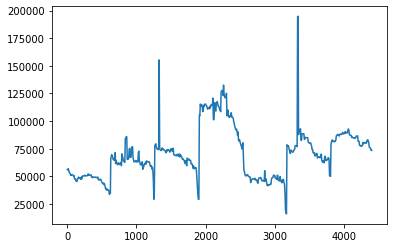

In [8]:
plt.plot(df[df.REGION=='AP'].ADRM)

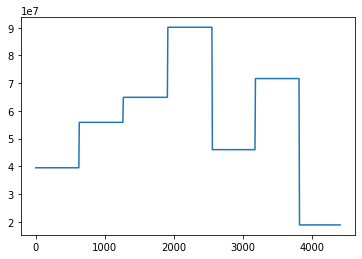

In [9]:
plt.plot(df[df.REGION=='AP'].ACTUALS)

In [485]:
df.head(3)

,DATE,REGION,YEAR_QUARTER,PROFIT_CTR,OPEN_COMMIT_VAL,OPEN_COMMIT_COUNT,OPEN_PROBABLE_VAL,OPEN_PROBABLE_COUNT,OPEN_UPSIDE_VAL,OPEN_UPSIDE_COUNT,...,WB_PROBABLE_COUNT,WB_UPSIDE_VAL,WB_UPSIDE_COUNT,VERBAL,ESTIMATED_IN,WON,ADRM,BUDGET,REGION2,ACTUALS
0,2018-01-01,AP,2018-Q1,M171I00070,6359.32335,45.0,49631.32615,385.0,170406.38675,2342.0,...,46.0,9299.58092,70.0,33999.71,0.00000,123.63829,55990.64950,45513.24473,ap,3.948256e+07
1,2018-01-01,EMNORTH,2018-Q1,S237000600,1685.84110,44.0,37053.13588,289.0,149054.15009,1308.0,...,34.0,11788.96354,63.0,26999.76,12.16456,231.30760,38751.14154,34683.70963,emnorth,3.906467e+07
2,2018-01-01,EMSOUTH,2018-Q1,MSIL00MI70,482.49033,7.0,25678.70798,273.0,95050.76179,1142.0,...,35.0,5582.12890,45.0,15599.66,469.27056,0.00000,26630.46887,19915.08873,emsouth,1.804038e+07


In [486]:
df['DV2'] = df['OPEN_COMMIT_VAL'] + df['OPEN_PROBABLE_VAL'] + df['OPEN_UPSIDE_VAL']

In [487]:
df.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'PROFIT_CTR', 'OPEN_COMMIT_VAL',
       'OPEN_COMMIT_COUNT', 'OPEN_PROBABLE_VAL', 'OPEN_PROBABLE_COUNT',
       'OPEN_UPSIDE_VAL', 'OPEN_UPSIDE_COUNT', 'WB_COMMIT_VAL',
       'WB_COMMIT_COUNT', 'WB_PROBABLE_VAL', 'WB_PROBABLE_COUNT',
       'WB_UPSIDE_VAL', 'WB_UPSIDE_COUNT', 'VERBAL', 'ESTIMATED_IN', 'WON',
       'ADRM', 'BUDGET', 'REGION2', 'ACTUALS', 'DV2'],
      dtype='object')

In [488]:
df_cloud = df.loc[:,['DATE', 'REGION', 'YEAR_QUARTER','OPEN_COMMIT_VAL','OPEN_PROBABLE_VAL','OPEN_UPSIDE_VAL',
                     'OPEN_COMMIT_COUNT','OPEN_PROBABLE_COUNT','OPEN_UPSIDE_COUNT', 'WB_COMMIT_COUNT','WB_PROBABLE_COUNT','WB_UPSIDE_COUNT',
                    'DV2', 'ESTIMATED_IN','BUDGET','VERBAL','ACTUAL']]

/Users/i513088/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



In [489]:
df_cloud = df_cloud.sort_values(by=['YEAR_QUARTER','REGION']).reset_index(drop=True)

# Handling time dimensions
### calculate day in quarter
###### some quarter have different durations - I need to ensure that the last days in the quarter match when joining historic data. Missing values for the first day will then simply be filled with the subsequent day

In [363]:
days = df_cloud[['DATE', 'YEAR_QUARTER']].drop_duplicates()

days['DayInQuarter'] = days.sort_values(['DATE'], ascending=[False]).groupby(['YEAR_QUARTER']).cumcount() + 1
days['DayInQuarter_asc'] = days.sort_values(['DATE'], ascending=[True]).groupby(['YEAR_QUARTER']).cumcount() + 1

In [364]:
df_cloud = pd.merge(df_cloud, days[['DATE', 'DayInQuarter', 'DayInQuarter_asc']], on = 'DATE', how = 'left')

### calculate index for quarter
###### having a running index for quarter will help calculate rolling snapshots

In [365]:
quarter = df_cloud[['YEAR_QUARTER']].drop_duplicates()

quarter['QuarterIndex'] = quarter.sort_values(['YEAR_QUARTER'], ascending=[True]).reset_index().index

quarter['QuarterIndex'] = quarter['QuarterIndex'] + 1

In [366]:
df_cloud = pd.merge(df_cloud, quarter[['YEAR_QUARTER', 'QuarterIndex']], on = 'YEAR_QUARTER', how = 'left')

# Fixing Data issues
###### the first two weeks of Q1 2019 contains incorrect values for budget - replacing them with values from day 15

In [367]:
#BudgetFix = df_cloud.loc[(df_cloud['YEAR_QUARTER'] == "2019-Q1")  & (df_subset['DayInQuarter_asc'] == 15), :]
#BudgetFix['BudgetFix'] = BudgetFix['BUDGET']

In [368]:
'''
df_cloud = pd.merge(df_subset, BudgetFix[['GLOBAL_01_CODE', 'QuarterIndex', 'BudgetFix']], 
                on = ['GLOBAL_01_CODE', 'QuarterIndex'], how = 'left')

df_cloud.loc[(df_subset.DayInQuarter_asc < 15) & (df_subset.CLOSING_QUARTER_ACTUAL == "2019-Q1"), 'BUDGET'] = df_subset['BudgetFix']

df_subset = df_subset.drop("BudgetFix", axis=1)
'''

'\ndf_cloud = pd.merge(df_subset, BudgetFix[[\'GLOBAL_01_CODE\', \'QuarterIndex\', \'BudgetFix\']], \n                on = [\'GLOBAL_01_CODE\', \'QuarterIndex\'], how = \'left\')\n\ndf_cloud.loc[(df_subset.DayInQuarter_asc < 15) & (df_subset.CLOSING_QUARTER_ACTUAL == "2019-Q1"), \'BUDGET\'] = df_subset[\'BudgetFix\']\n\ndf_subset = df_subset.drop("BudgetFix", axis=1)\n'

## <font color='red'>Manipulate Quarter Index to "bootstrap" - swapping the holdout sample.<font>

In [369]:
#df_subset.loc[df_subset.CLOSING_QUARTER_ACTUAL == '2018-Q1', 'QuarterIndex'] = 1
#df_subset.loc[df_subset.CLOSING_QUARTER_ACTUAL == '2019-Q1', 'QuarterIndex'] = 5

# creation of Analytical dataset

#### Initiating dataset by selecting straightforward entries first (time dimensions, dependent variable, Estimated In, Open Pipe)

In [370]:
#df_subset['DV2'] = df_subset.CurrentQuarter_Commit + df_subset.CurrentQuarterProbable + df_subset.CurrentQuarter_Upside

# Exploratory Analysis

### Opportunities with a qualification status of upside / probable show a different closing probability throughout the quarter. To account for this teh open opportunity value need to be adjusted.

In [371]:
df_cloud.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'OPEN_COMMIT_VAL',
       'OPEN_PROBABLE_VAL', 'OPEN_UPSIDE_VAL', 'OPEN_COMMIT_COUNT',
       'OPEN_PROBABLE_COUNT', 'OPEN_UPSIDE_COUNT', 'WB_COMMIT_COUNT',
       'WB_PROBABLE_COUNT', 'WB_UPSIDE_COUNT', 'DV2', 'ESTIMATED_IN', 'BUDGET',
       'VERBAL', 'ACTUAL', 'DayInQuarter', 'DayInQuarter_asc', 'QuarterIndex'],
      dtype='object')

In [375]:
dummy.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'OPEN_COMMIT_VAL',
       'OPEN_PROBABLE_VAL', 'OPEN_UPSIDE_VAL', 'OPEN_COMMIT_COUNT',
       'OPEN_PROBABLE_COUNT', 'OPEN_UPSIDE_COUNT', 'WB_COMMIT_COUNT',
       'WB_PROBABLE_COUNT', 'WB_UPSIDE_COUNT', 'DV2', 'ESTIMATED_IN', 'BUDGET',
       'VERBAL', 'ACTUAL', 'DayInQuarter', 'DayInQuarter_asc', 'QuarterIndex',
       'FactorCommit', 'FactorProbable', 'FactorUpside'],
      dtype='object')

In [376]:
dummy = df_cloud.copy(deep=True)

dummy.loc[dummy.DayInQuarter > 90, 'DayInQuarter'] = 90

'''dummy = dummy[['REGION', 'DayInQuarter', 'Count_Open_AB', 'Count_Open_CD', 'Count_Open_EF', 'Count_Open_Commit', 'Count_Open_Probable', 'Count_Open_Upside',
               'Count_AB', 'Count_CD', 'Count_EF', 'Count_Commit', 'Count_Probable', 'Count_Upside',
               'Open_Commit', 'Open_Probable', 'Open_Upside', 'CurrentQuarter_Commit', 'CurrentQuarterProbable', 'CurrentQuarter_Upside']]'''

dummy['FactorCommit'] = dummy['WB_COMMIT_COUNT'] / dummy['OPEN_COMMIT_COUNT']
dummy['FactorProbable'] = dummy['WB_PROBABLE_COUNT'] / dummy['OPEN_PROBABLE_COUNT']
dummy['FactorUpside'] = dummy['WB_UPSIDE_COUNT'] / dummy['OPEN_UPSIDE_COUNT']

ClosingRates = dummy[['REGION', 'DayInQuarter', 'FactorCommit', 'FactorProbable', 'FactorUpside']]

ClosingRates = dummy.groupby(by = ['REGION', 'DayInQuarter']).mean().reset_index()


### <font color='red'>This step, we get the value 'OpenPipe_adj', which we used input variable 'WeightedPipe' later!!<font>

In [377]:
df_cloud = pd.merge(df_cloud, ClosingRates[['REGION', 'DayInQuarter', 'FactorCommit', 'FactorProbable', 'FactorUpside']], 
                on = ['REGION', 'DayInQuarter'], how = 'left')

df_cloud['Open_Commit_adj'] = df_cloud['OPEN_COMMIT_VAL'] * df_cloud['FactorCommit']
df_cloud['Open_Probable_adj'] = df_cloud['OPEN_PROBABLE_VAL'] * df_cloud['FactorProbable']
df_cloud['Open_Upside_adj'] = df_cloud['OPEN_UPSIDE_VAL'] * df_cloud['FactorUpside']
df_cloud['OpenPipe_adj'] = df_cloud['Open_Upside_adj'] + df_cloud['Open_Probable_adj'] + df_cloud['Open_Commit_adj']

df_cloud['OpenPipe_adj'] = df_cloud['OpenPipe_adj'].astype(float)

In [378]:
df_cloud.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'OPEN_COMMIT_VAL',
       'OPEN_PROBABLE_VAL', 'OPEN_UPSIDE_VAL', 'OPEN_COMMIT_COUNT',
       'OPEN_PROBABLE_COUNT', 'OPEN_UPSIDE_COUNT', 'WB_COMMIT_COUNT',
       'WB_PROBABLE_COUNT', 'WB_UPSIDE_COUNT', 'DV2', 'ESTIMATED_IN', 'BUDGET',
       'VERBAL', 'ACTUAL', 'DayInQuarter', 'DayInQuarter_asc', 'QuarterIndex',
       'FactorCommit', 'FactorProbable', 'FactorUpside', 'Open_Commit_adj',
       'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj'],
      dtype='object')

In [379]:
ad_1 = df_cloud[['DATE', 'REGION', 'YEAR_QUARTER', 'DayInQuarter', 'DayInQuarter_asc', 'QuarterIndex',
                'OPEN_COMMIT_VAL', 'OPEN_PROBABLE_VAL', 'OPEN_UPSIDE_VAL', 
                 'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj', 'ESTIMATED_IN', 'BUDGET',
                'VERBAL', 'ACTUAL', 'DV2']]


### Linearity based on last quarter

In [380]:
dummy0 = ad_1 #df_cloud[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy1 = dummy0.copy(deep=True)

dummy1['QuarterIndex'] = dummy1['QuarterIndex'] + 1
dummy1['ESTIMATED_IN_tm1'] = dummy1['ESTIMATED_IN']
dummy1['DV_tm1'] = dummy1['DV2']
dummy1['BUDGET_tm1'] = dummy1['BUDGET']

dummy0 = pd.merge(dummy0, dummy1[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm1', 'DV_tm1', 'BUDGET_tm1']], 
                  on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')


In [381]:
dummy0['Linearity_EstIn_1Q'] = dummy0.DV_tm1 / dummy0.ESTIMATED_IN_tm1
dummy0['Linearity_Budget_1Q'] = dummy0.DV_tm1 / dummy0.BUDGET_tm1

In [382]:
ad_2 = pd.merge(ad_1, dummy0[['REGION', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q']], 
                on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 2

In [383]:
dummy0 = ad_1 #df_cloud[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy2 = dummy0.copy(deep=True)

dummy2['QuarterIndex'] = dummy2['QuarterIndex'] + 2
dummy2['ESTIMATED_IN_tm2'] = dummy2['ESTIMATED_IN']
dummy2['DV_tm2'] = dummy2['DV2']
dummy2['BUDGET_tm2'] = dummy2['BUDGET']

dummy0 = pd.merge(dummy0, dummy2[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm2', 'DV_tm2', 'BUDGET_tm2']], 
                  on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [384]:
dummy0['Linearity_EstIn_2Q'] = dummy0.DV_tm2 / dummy0.ESTIMATED_IN_tm2
dummy0['Linearity_Budget_2Q'] = dummy0.DV_tm2 / dummy0.BUDGET_tm2

In [385]:
ad_3 = pd.merge(ad_2, dummy0[['REGION', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_2Q', 'Linearity_Budget_2Q']], 
                on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 3

In [386]:
dummy0 = ad_1  #df_cloud[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy3 = dummy0.copy(deep=True)

dummy3['QuarterIndex'] = dummy3['QuarterIndex'] + 3
dummy3['ESTIMATED_IN_tm3'] = dummy3['ESTIMATED_IN']
dummy3['DV_tm3'] = dummy3['DV2']
dummy3['BUDGET_tm3'] = dummy3['BUDGET']

dummy0 = pd.merge(dummy0, dummy3[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm3', 'DV_tm3', 'BUDGET_tm3']], 
                  on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [387]:
dummy0['Linearity_EstIn_3Q'] = dummy0.DV_tm3 / dummy0.ESTIMATED_IN_tm3
dummy0['Linearity_Budget_3Q'] = dummy0.DV_tm3 / dummy0.BUDGET_tm3

In [388]:
ad_4 = pd.merge(ad_3, dummy0[['REGION', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_3Q', 'Linearity_Budget_3Q']], 
                on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 4

In [389]:
dummy0 = ad_1  #df_cloud[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy4 = dummy0.copy(deep=True)

dummy4['QuarterIndex'] = dummy4['QuarterIndex'] + 4
dummy4['ESTIMATED_IN_tm4'] = dummy4['ESTIMATED_IN']
dummy4['DV_tm4'] = dummy4['DV2']
dummy4['BUDGET_tm4'] = dummy4['BUDGET']

dummy0 = pd.merge(dummy0, dummy4[['REGION', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm4', 'DV_tm4', 'BUDGET_tm4']], 
                  on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [390]:
dummy0['Linearity_EstIn_4Q'] = dummy0.DV_tm4 / dummy0.ESTIMATED_IN_tm4
dummy0['Linearity_Budget_4Q'] = dummy0.DV_tm4 / dummy0.BUDGET_tm4

In [391]:
ad_5 = pd.merge(ad_4, dummy0[['REGION', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_4Q', 'Linearity_Budget_4Q']], 
                on = ['REGION', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### build rolling average
#### historic quarter are not necessarily availble. Thus a rolling average is only build based on available data by replacing missing values with 0 and then count non zeros for average creation

In [392]:
# replacing missing values

ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_1Q"]) == True, 'Linearity_EstIn_1Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_2Q"]) == True, 'Linearity_EstIn_2Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_3Q"]) == True, 'Linearity_EstIn_3Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_4Q"]) == True, 'Linearity_EstIn_4Q'] = 0

ad_5.loc[pd.isnull(ad_5["Linearity_Budget_1Q"]) == True, 'Linearity_Budget_1Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_2Q"]) == True, 'Linearity_Budget_2Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_3Q"]) == True, 'Linearity_Budget_3Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_4Q"]) == True, 'Linearity_Budget_4Q'] = 0

ad_5.loc[ad_5.Linearity_EstIn_1Q < 0, 'Linearity_EstIn_1Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_2Q < 0, 'Linearity_EstIn_2Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_3Q < 0, 'Linearity_EstIn_3Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_4Q < 0, 'Linearity_EstIn_4Q'] = 0

ad_5.loc[ad_5.Linearity_Budget_1Q < 0, 'Linearity_Budget_1Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_2Q < 0, 'Linearity_Budget_2Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_3Q < 0, 'Linearity_Budget_3Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_4Q < 0, 'Linearity_Budget_4Q'] = 0

# count populated entries

ad_5['LinearityEstIn_Counter'] = 0
ad_5['LinearityBudget_Counter'] = 0


ad_5.loc[ad_5.Linearity_EstIn_1Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter'] + 1
ad_5.loc[ad_5.Linearity_EstIn_2Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1
ad_5.loc[ad_5.Linearity_EstIn_3Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1
ad_5.loc[ad_5.Linearity_EstIn_4Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1

ad_5.loc[ad_5.Linearity_Budget_1Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_2Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_3Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_4Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1


# rolling average

ad_5['LinearityEstIn_rolling'] =0
ad_5['LinearityBudget_rolling'] = 0

ad_5['LinearityEstIn_rolling'] = (ad_5['Linearity_EstIn_1Q'] + 
                                 ad_5['Linearity_EstIn_2Q'] +
                                 ad_5['Linearity_EstIn_3Q'] +
                                 ad_5['Linearity_EstIn_4Q']) / ad_5['LinearityEstIn_Counter'] * ad_5['ESTIMATED_IN']
ad_5['LinearityBudget_rolling'] = (ad_5['Linearity_Budget_1Q'] + 
                                 ad_5['Linearity_Budget_2Q'] +
                                 ad_5['Linearity_Budget_3Q'] +
                                 ad_5['Linearity_Budget_4Q']) / ad_5['LinearityBudget_Counter'] * ad_5['BUDGET']

### add delta EstIn / OpenPipe
#### calculating the difference between two snapshots to be used as an independent variable

In [393]:
dummy0 = ad_1  #df_cloud[['REGION', 'DayInQuarter_asc', 'QuarterIndex', 'ESTIMATED_IN']]
dummy1 = dummy0.copy(deep=True)

dummy1['DayInQuarter_asc'] = dummy1['DayInQuarter_asc'] + 1
dummy1['ESTIMATED_IN_dm1'] = dummy1['ESTIMATED_IN']
#dummy1['OpenPipe_dm1'] = dummy1['OpenPipe']

dummy0 = pd.merge(dummy0, dummy1[['REGION', 'DayInQuarter_asc', 'QuarterIndex', 'ESTIMATED_IN_dm1']], 
                  on = ['REGION', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

In [394]:
dummy0['Delta_EstIn'] = dummy0.ESTIMATED_IN - dummy0.ESTIMATED_IN_dm1 
#dummy0['Delta_OpenPipe'] = dummy0.OpenPipe - dummy0.OpenPipe_dm1 

In [395]:
ad_6 = pd.merge(ad_5, dummy0[['REGION', 'DayInQuarter_asc', 'QuarterIndex', 'Delta_EstIn']], 
                on = ['REGION', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

# Final Variable Selection

In [396]:
ad_6.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'DayInQuarter', 'DayInQuarter_asc',
       'QuarterIndex', 'OPEN_COMMIT_VAL', 'OPEN_PROBABLE_VAL',
       'OPEN_UPSIDE_VAL', 'Open_Commit_adj', 'Open_Probable_adj',
       'Open_Upside_adj', 'OpenPipe_adj', 'ESTIMATED_IN', 'BUDGET', 'VERBAL',
       'ACTUAL', 'DV2', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
       'Linearity_EstIn_2Q', 'Linearity_Budget_2Q', 'Linearity_EstIn_3Q',
       'Linearity_Budget_3Q', 'Linearity_EstIn_4Q', 'Linearity_Budget_4Q',
       'LinearityEstIn_Counter', 'LinearityBudget_Counter',
       'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn'],
      dtype='object')

In [397]:
AnalyticalData = ad_6[['DATE', 'REGION', 'YEAR_QUARTER',
                      'DayInQuarter',
                      'DayInQuarter_asc',
                      'QuarterIndex',
                      'OPEN_COMMIT_VAL',
                      'OPEN_PROBABLE_VAL', 
                      'OPEN_UPSIDE_VAL',
                      'DV2',
                      'BUDGET',
                      'ESTIMATED_IN',
                      'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj',
                      'Linearity_EstIn_1Q',
                      'Linearity_Budget_1Q',
                      'LinearityEstIn_rolling',
                      'LinearityBudget_rolling',
                      'Delta_EstIn']]

AnalyticalData['Linearity_EstIn_1Q'] = AnalyticalData['Linearity_EstIn_1Q'] * AnalyticalData['ESTIMATED_IN']
AnalyticalData['Linearity_Budget_1Q'] = AnalyticalData['Linearity_Budget_1Q'] * AnalyticalData['BUDGET']

AnalyticalData = AnalyticalData.replace([np.inf, -np.inf], np.nan)

/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### not all quarter have the same amount of days - in these cases missing values for independet variables can occur and are replaced with data from the following day. This data would be available given that the Analytical dataset contains only historic data resp. derivates from historic data
###### populate day 2 with day 3

In [398]:
dummy0 = AnalyticalData.loc[AnalyticalData['DayInQuarter_asc'] == 3,
    ['REGION', 'DayInQuarter_asc', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
    'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn']].copy(deep=True)
#dummy1 = dummy0.copy(deep=True)

dummy0['DayInQuarter_asc'] = dummy0['DayInQuarter_asc'] - 1
dummy0['fix1'] = dummy0['Linearity_EstIn_1Q']
dummy0['fix2'] = dummy0['Linearity_Budget_1Q']
dummy0['fix3'] = dummy0['LinearityEstIn_rolling']
dummy0['fix4'] = dummy0['LinearityBudget_rolling']
dummy0['fix5'] = dummy0['Delta_EstIn']
#dummy0['fix6'] = dummy0['Delta_OpenPipe']

AnalyticalData = pd.merge(AnalyticalData, dummy0[['REGION', 'DayInQuarter_asc', 'QuarterIndex', 
                                                  'fix1', 'fix2', 'fix3', 'fix4', 'fix5']], 
                  on = ['REGION', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Linearity_EstIn_1Q'] = AnalyticalData['fix1']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Linearity_Budget_1Q'] = AnalyticalData['fix2']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'LinearityEstIn_rolling'] = AnalyticalData['fix3']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'LinearityBudget_rolling'] = AnalyticalData['fix4']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_EstIn"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Delta_EstIn'] = AnalyticalData['fix5']
#AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True) & 
#                   (AnalyticalData.DayInQuarter_asc == 2), 'Delta_OpenPipe'] = AnalyticalData['fix6']

AnalyticalData = AnalyticalData.drop("fix1", axis=1)
AnalyticalData = AnalyticalData.drop("fix2", axis=1)
AnalyticalData = AnalyticalData.drop("fix3", axis=1)
AnalyticalData = AnalyticalData.drop("fix4", axis=1)
AnalyticalData = AnalyticalData.drop("fix5", axis=1)
#AnalyticalData = AnalyticalData.drop("fix6", axis=1)

###### populate day 1 with day 2

In [399]:
dummy0 = AnalyticalData.loc[AnalyticalData['DayInQuarter_asc'] == 2,
    ['REGION', 'DayInQuarter_asc', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
    'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn']].copy(deep=True)
#dummy1 = dummy0.copy(deep=True)

dummy0['DayInQuarter_asc'] = dummy0['DayInQuarter_asc'] - 1
dummy0['fix1'] = dummy0['Linearity_EstIn_1Q']
dummy0['fix2'] = dummy0['Linearity_Budget_1Q']
dummy0['fix3'] = dummy0['LinearityEstIn_rolling']
dummy0['fix4'] = dummy0['LinearityBudget_rolling']
dummy0['fix5'] = dummy0['Delta_EstIn']
#dummy0['fix6'] = dummy0['Delta_OpenPipe']

AnalyticalData = pd.merge(AnalyticalData, dummy0[['REGION', 'DayInQuarter_asc', 'QuarterIndex', 
                                                  'fix1', 'fix2', 'fix3', 'fix4', 'fix5']], 
                  on = ['REGION', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Linearity_EstIn_1Q'] = AnalyticalData['fix1']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Linearity_Budget_1Q'] = AnalyticalData['fix2']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'LinearityEstIn_rolling'] = AnalyticalData['fix3']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'LinearityBudget_rolling'] = AnalyticalData['fix4']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_EstIn"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Delta_EstIn'] = AnalyticalData['fix5']
#AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True) & 
#                   (AnalyticalData.DayInQuarter_asc == 1), 'Delta_OpenPipe'] = AnalyticalData['fix6']

AnalyticalData = AnalyticalData.drop("fix1", axis=1)
AnalyticalData = AnalyticalData.drop("fix2", axis=1)
AnalyticalData = AnalyticalData.drop("fix3", axis=1)
AnalyticalData = AnalyticalData.drop("fix4", axis=1)
AnalyticalData = AnalyticalData.drop("fix5", axis=1)
#AnalyticalData = AnalyticalData.drop("fix6", axis=1)

###### populate remaining missing values

In [400]:
AnalyticalData.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'DayInQuarter', 'DayInQuarter_asc',
       'QuarterIndex', 'OPEN_COMMIT_VAL', 'OPEN_PROBABLE_VAL',
       'OPEN_UPSIDE_VAL', 'DV2', 'BUDGET', 'ESTIMATED_IN', 'Open_Commit_adj',
       'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj',
       'Linearity_EstIn_1Q', 'Linearity_Budget_1Q', 'LinearityEstIn_rolling',
       'LinearityBudget_rolling', 'Delta_EstIn'],
      dtype='object')

In [401]:
AnalyticalData.loc[pd.isnull(AnalyticalData["ESTIMATED_IN"]) == True, 'ESTIMATED_IN'] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["OpenPipe"]) == True, "OpenPipe"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["OpenPipe_adj"]) == True, "OpenPipe_adj"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_AB"]) == True, "Open_AB"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_CD"]) == True, "Open_CD"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_EF"]) == True, "Open_EF"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Commit_adj"]) == True, "Open_Commit_adj"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Probable_adj"]) == True, "Open_Probable_adj"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Upside_adj"]) == True, "Open_Upside_adj"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Commit"]) == True, "Open_Commit"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Probable"]) == True, "Open_Probable"] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Upside"]) == True, "Open_Upside"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True, 'Linearity_EstIn_1Q'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True, 'Linearity_Budget_1Q'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True, 'LinearityEstIn_rolling'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True, 'LinearityBudget_rolling'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Delta_EstIn"]) == True, 'Delta_EstIn'] = 0
#AnalyticalData.loc[pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True, 'Delta_OpenPipe'] = 0

AnalyticalData.loc[pd.isnull(AnalyticalData["BUDGET"]) == True, 'BUDGET'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["OPEN_COMMIT_VAL"]) == True, 'OPEN_COMMIT_VAL'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["OPEN_PROBABLE_VAL"]) == True, 'OPEN_PROBABLE_VAL'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["OPEN_UPSIDE_VAL"]) == True, 'OPEN_UPSIDE_VAL'] = 0

### There are outliers in the data - thus the independent variables which represents estimator of the depnedent variable get limited to a corridor between 
#### upper limit: 60% of budget on day 1 to 30% of budget on day 90
#### lower limit: 30% of budget on day 1 to 0% of budget on day 90

### <font color='red'> Here how to limit the data within the LowerBoundary and UpperBoundary？？？<font>

In [53]:
'''
AnalyticalData['UpperBoundary'] = AnalyticalData['BUDGET'] * 0.6 - (AnalyticalData['BUDGET'] * 0.6 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 180))
AnalyticalData['LowerBoundary'] = AnalyticalData['BUDGET'] * 0.3 - (AnalyticalData['BUDGET'] * 0.3 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 90))

AnalyticalData.loc[AnalyticalData.UpperBoundary < 0, 'UpperBoundary'] = 0
AnalyticalData.loc[AnalyticalData.LowerBoundary < 0, 'LowerBoundary'] = 0

AnalyticalData.loc[AnalyticalData.Linearity_Budget_1Q > AnalyticalData.UpperBoundary, 
                   'Linearity_Budget_1Q'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.Linearity_EstIn_1Q > AnalyticalData.UpperBoundary, 
                   'Linearity_EstIn_1Q'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.LinearityEstIn_rolling > AnalyticalData.UpperBoundary, 
                   'LinearityEstIn_rolling'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.LinearityBudget_rolling > AnalyticalData.UpperBoundary, 
                   'LinearityBudget_rolling'] = AnalyticalData.UpperBoundary

AnalyticalData.loc[AnalyticalData.Linearity_Budget_1Q < AnalyticalData.LowerBoundary, 
                   'Linearity_Budget_1Q'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.Linearity_EstIn_1Q < AnalyticalData.LowerBoundary, 
                   'Linearity_EstIn_1Q'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.LinearityEstIn_rolling < AnalyticalData.LowerBoundary, 
                   'LinearityEstIn_rolling'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.LinearityBudget_rolling < AnalyticalData.LowerBoundary, 
                   'LinearityBudget_rolling'] = AnalyticalData.LowerBoundary
'''

"\nAnalyticalData['UpperBoundary'] = AnalyticalData['BUDGET'] * 0.6 - (AnalyticalData['BUDGET'] * 0.6 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 180))\nAnalyticalData['LowerBoundary'] = AnalyticalData['BUDGET'] * 0.3 - (AnalyticalData['BUDGET'] * 0.3 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 90))\n\nAnalyticalData.loc[AnalyticalData.UpperBoundary < 0, 'UpperBoundary'] = 0\nAnalyticalData.loc[AnalyticalData.LowerBoundary < 0, 'LowerBoundary'] = 0\n\nAnalyticalData.loc[AnalyticalData.Linearity_Budget_1Q > AnalyticalData.UpperBoundary, \n                   'Linearity_Budget_1Q'] = AnalyticalData.UpperBoundary\nAnalyticalData.loc[AnalyticalData.Linearity_EstIn_1Q > AnalyticalData.UpperBoundary, \n                   'Linearity_EstIn_1Q'] = AnalyticalData.UpperBoundary\nAnalyticalData.loc[AnalyticalData.LinearityEstIn_rolling > AnalyticalData.UpperBoundary, \n                   'LinearityEstIn_rolling'] = AnalyticalData.UpperBoundary\nAnalyticalData.loc[AnalyticalData.LinearityBudget_

In [54]:
# AnalyticalData.to_csv("/Users/i513088/Desktop/Final-model/AnalyticalData_model1_CountQualification.csv")

# AnalyticalData = pd.read_csv("/Users/i513088/Desktop/Final-model/AnalyticalData_model1_CountQualification.csv")

In [402]:
#AnalyticalData.to_csv("./AnalyticalData.csv")

In [498]:
AnalyticalData = pd.read_csv("./AnalyticalData.csv", sep = ',', index_col=0 )

# ------------------------------------------
# MODELING
# ------------------------------------------

In [330]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.externals import joblib

In [501]:
def train_model(model, param_grid, X=[], y=[], eval_set=[]):
        
    # setup grid search parameters
    gsearch = GridSearchCV(model, param_grid, verbose=0)

    gsearch.fit(X,y)

    # extract best model from the grid
    model = gsearch.best_estimator_        
    best_idx = gsearch.best_index_


    y_train_pred = model.predict(X)
    
    #joblib.dump(model, '/Users/i513088/Desktop/'+'count_'+str(model)[:20]+'.pkl')
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('Train MAPE:',np.mean(MAPE(y_train_pred, y)))
    
    return model


def model_predict(model, x_test,y_test):
    
    y_predict = model.predict(x_test)

    mape = np.mean(MAPE(y_predict, y_test))
    
    y_pred_model1[model] = pd.Series(y_predict)
    
    y_pred_model1[str(model)+'mape'] = pd.Series(MAPE(y_predict, y_test))
    
    #y_pred_model1.to_csv('/Users/i513088/Desktop/y_pred_model1-q7.csv')

    print('The model',model, 'test mape is:', mape)
    print('Finished!')

    return y_predict
    

#### creating datasets

In [502]:
AnalyticalData.YEAR_QUARTER.unique()

array(['2018-Q1', '2018-Q2', '2018-Q3', '2018-Q4', '2019-Q1', '2019-Q2',
       '2019-Q3'], dtype=object)

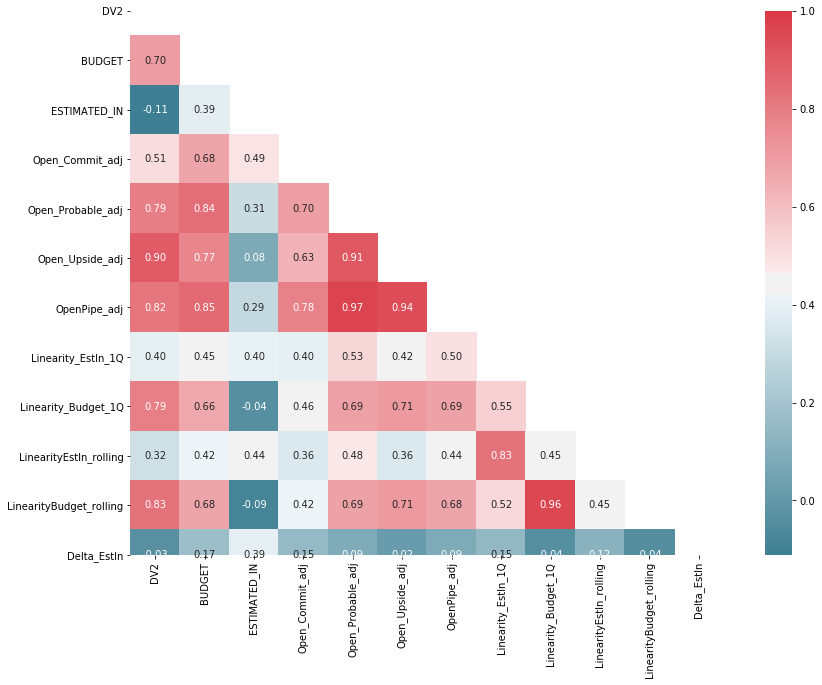

In [404]:
features = AnalyticalData.loc[: , 'DV2' : 'Delta_EstIn']
#features = pd.concat([features, AnalyticalData['DV2']], axis=1)

plt.figure(figsize=(15, 10))  
colnm = features.columns.tolist()
mcorr = features[colnm].corr(method="spearman")  
mask = np.zeros_like(mcorr, dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True 
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
g = sns.heatmap(mcorr,  mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()


In [406]:
AnalyticalData.columns

Index(['DATE', 'REGION', 'YEAR_QUARTER', 'DayInQuarter', 'DayInQuarter_asc',
       'QuarterIndex', 'OPEN_COMMIT_VAL', 'OPEN_PROBABLE_VAL',
       'OPEN_UPSIDE_VAL', 'DV2', 'BUDGET', 'ESTIMATED_IN', 'Open_Commit_adj',
       'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj',
       'Linearity_EstIn_1Q', 'Linearity_Budget_1Q', 'LinearityEstIn_rolling',
       'LinearityBudget_rolling', 'Delta_EstIn'],
      dtype='object')

In [408]:
for quarter in list(AnalyticalData.QuarterIndex.unique()):
        
    train = AnalyticalData[(AnalyticalData.QuarterIndex != quarter)].sort_values(['YEAR_QUARTER','REGION']).reset_index(drop=True)
    holdout = AnalyticalData[(AnalyticalData.QuarterIndex == quarter)].sort_values(['YEAR_QUARTER','REGION']).reset_index(drop=True)

    train_x=train.loc[: , ['ESTIMATED_IN', 'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj',
         'Linearity_EstIn_1Q',
         'Linearity_Budget_1Q',
         'LinearityEstIn_rolling',
         'LinearityBudget_rolling',
         'Delta_EstIn']]
    train_y=train.DV2

    test_x=holdout.loc[: , ['ESTIMATED_IN', 'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj',
         'Linearity_EstIn_1Q',
         'Linearity_Budget_1Q',
         'LinearityEstIn_rolling',
         'LinearityBudget_rolling',
         'Delta_EstIn']]
    test_y=holdout.DV2
    
    
    X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, test_size=0.15)
    

    model_name = 'Linear'
    model = linear_model.LinearRegression()
    fit_intercept = [False]
    param_grid = {'fit_intercept': fit_intercept}
    LinearReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
    LinearReg_Pred = model_predict(LinearReg,test_x,test_y)
    LinearReg_coef = LinearReg.coef_


    model_name = 'Lasso'
    model = Lasso()
    fit_intercept = [False]
    alph_range = np.arange(0.1,6,0.25)
    param_grid = {'alpha': alph_range, 'fit_intercept': fit_intercept}
    LassoReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
    LassoReg_coef = LassoReg.coef_
    LassoReg_Pred = model_predict(LassoReg,test_x,test_y)


    model_name = 'RandomForest'
    model = RandomForestRegressor()
    param_grid = {'n_estimators':[100,150,200],
                  'min_samples_split':[2,4,6]
                 }
    RF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])

    RF_Pred = model_predict(RF,test_x,test_y)


    result = pd.DataFrame({'DATE':holdout.DATE, 'REGION':holdout.REGION,'YEAR_QUARTER':holdout.YEAR_QUARTER,
                   'DV2':holdout.DV2,'lr_Pred':LinearReg_Pred,'lasso_Pred':LassoReg_Pred,'rf_Pred':RF_Pred})

    result.to_csv('./q' + str(quarter) + '.csv', index = None, header=True, sep=';', decimal=',')


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)
----------------------
Train MAPE: 26.9362455857826
The model LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False) test mape is: 180.49217692492323
Finished!
----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 26.936246156420143
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 180.53230489612912
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.4157553006818304
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 39.886133125789975
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 21.732389488260537
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.2279434441286585
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 38.28734544569661
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 27.100745459010998
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.32584663747281
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 51.711131646010074
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 31.900134248297647
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.2845184055794543
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 39.42260438215583
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 20.684452724263807
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.4242247308305815
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10578856310.487793, tolerance: 9436787240.566723

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10613454769.562012, tolerance: 8809472164.30825

/Users/i513088/anaconda3/

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 38.72429664466618
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 22.00616232008208
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.6534668247950504
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 34.89778628963228
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 66.76312322948903
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.321676357456778
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm

In [503]:
'''
model_name = 'Linear'
model = linear_model.LinearRegression()
fit_intercept = [False]
param_grid = {'fit_intercept': fit_intercept}
LinearReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
LinearReg_Pred = model_predict(LinearReg,test_x,test_y)
LinearReg_coef = LinearReg.coef_


model_name = 'Lasso'
model = Lasso()
fit_intercept = [False]
alph_range = np.arange(0.1,6,0.25)
param_grid = {'alpha': alph_range, 'fit_intercept': fit_intercept}
LassoReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
LassoReg_coef = LassoReg.coef_
LassoReg_Pred = model_predict(LassoReg,test_x,test_y)


model_name ='ElasticNet'
model = ElasticNet()
param_grid = {'alpha': np.arange(0.1,6,0.25),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}
ElasticReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
ElasticReg_coef = ElasticReg.coef_

ElasticReg_Pred = model_predict(ElasticReg,test_x, test_y)



model_name = 'GradientBoosting'
model = GradientBoostingRegressor()
param_grid = {'n_estimators':[150,250,350],
              'max_depth':[2,3,4,5],
              'min_samples_split':[5,6,7]}
GBM = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
GBM_Pred = model_predict(GBM, test_x,test_y)
'''

'''
model_name = 'XGB'
model = XGBRegressor()
param_grid = {'n_estimators':[100,200,300,400],
              'max_depth':[2,3,4,5],
             }
XGB = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
XGB_Pred = model_predict(XGB,test_x,test_y)



model_name = 'RandomForest'
model = RandomForestRegressor()
param_grid = {'n_estimators':[100,150,200],
              'min_samples_split':[2,4,6]
             }
RF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])

RF_Pred = model_predict(RF,test_x,test_y)
'''

"\nmodel_name = 'XGB'\nmodel = XGBRegressor()\nparam_grid = {'n_estimators':[100,200,300,400],\n              'max_depth':[2,3,4,5],\n             }\nXGB = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])\nXGB_Pred = model_predict(XGB,test_x,test_y)\n\n\n\nmodel_name = 'RandomForest'\nmodel = RandomForestRegressor()\nparam_grid = {'n_estimators':[100,150,200],\n              'min_samples_split':[2,4,6]\n             }\nRF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])\n\nRF_Pred = model_predict(RF,test_x,test_y)\n"

In [505]:
final_fc.head(3)

,DATE,REGION,YEAR_QUARTER,DV2,lr_Pred,lasso_Pred,rf_Pred,MAPE_lasso,MAPE_lr,MAPE_rf,OpenPipe_adj,MAPE_adj
0,2018-01-01,AP,2018-Q1,226397.03625,79247.893501,79247.895848,137261.360036,0.649961,0.649961,0.393714,21977.611052,0.902924
1,2018-01-02,AP,2018-Q1,221737.69996,75976.557851,75976.560607,135539.081201,0.657358,0.657358,0.388741,21167.502653,0.904538
2,2018-01-03,AP,2018-Q1,209660.08457,72795.727917,72795.729773,137787.335671,0.652792,0.652792,0.342806,21986.250938,0.895134


In [511]:
'''q1 = pd.read_csv('./q1.csv', sep = ';', decimal=',').reset_index(drop=True)
q2 = pd.read_csv('./q2.csv', sep = ';', decimal=',').reset_index(drop=True)
q3 = pd.read_csv('./q3.csv', sep = ';', decimal=',').reset_index(drop=True)
q4 = pd.read_csv('./q4.csv', sep = ';', decimal=',').reset_index(drop=True)
q5 = pd.read_csv('./q5.csv', sep = ';', decimal=',').reset_index(drop=True)
q6 = pd.read_csv('./q6.csv', sep = ';', decimal=',').reset_index(drop=True)
q7 = pd.read_csv('./q7.csv', sep = ';', decimal=',').reset_index(drop=True)

final_fc = pd.concat([q1,q2,q3,q4,q5,q6,q7]).reset_index(drop=True)
'''

final_fc = pd.read_csv('./cloud/final_fc.csv', sep = ';', decimal=',', index_col=0) 

final_fc = pd.merge(final_fc, AnalyticalData[['DATE','REGION','YEAR_QUARTER', 'OpenPipe_adj']],
                   on=['DATE','REGION','YEAR_QUARTER'], how='left')

final_fc['MAPE_lasso'] = abs(final_fc['lasso_Pred'] - final_fc['DV2']) / final_fc['DV2']
final_fc['MAPE_lr'] = abs(final_fc['lr_Pred'] - final_fc['DV2']) / final_fc['DV2']
final_fc['MAPE_rf'] = abs(final_fc['rf_Pred'] - final_fc['DV2']) / final_fc['DV2']
final_fc['MAPE_adj'] = abs(final_fc['OpenPipe_adj'] - final_fc['DV2']) / final_fc['DV2']

#final_fc = final_fc[(final_fc.DV2!=0)]

#final_fc.to_csv('./final_fc.csv', sep = ';', decimal=',')

In [514]:
final_fc.head(3)

,DATE,REGION,YEAR_QUARTER,DV2,lr_Pred,lasso_Pred,rf_Pred,MAPE_lasso,MAPE_lr,MAPE_rf,OpenPipe_adj,MAPE_adj
0,2018-01-01,AP,2018-Q1,226397.03625,79247.893501,79247.895848,137261.360036,0.649961,0.649961,0.393714,21977.611052,0.902924
1,2018-01-02,AP,2018-Q1,221737.69996,75976.557851,75976.560607,135539.081201,0.657358,0.657358,0.388741,21167.502653,0.904538
2,2018-01-03,AP,2018-Q1,209660.08457,72795.727917,72795.729773,137787.335671,0.652792,0.652792,0.342806,21986.250938,0.895134


In [515]:
mape = final_fc.groupby(['REGION','YEAR_QUARTER']).mean()
mape = mape[['MAPE_lasso', 'MAPE_lr', 'MAPE_rf']]
mape = mape.replace([np.inf, -np.inf], 0)
#mape.to_csv('./final_quarterly_MAPE.csv', sep = ';', decimal=',')

# MAPE global

In [518]:
mape = pd.read_csv('./final_quarterly_MAPE.csv', sep = ';', decimal=',')

In [519]:
mape[(mape.YEAR_QUARTER=='2018-Q2')|
    (mape.YEAR_QUARTER=='2018-Q3')| (mape.YEAR_QUARTER=='2018-Q4')|
    (mape.YEAR_QUARTER=='2019-Q1')| (mape.YEAR_QUARTER=='2019-Q2')].mean()

MAPE_lasso    0.187038
MAPE_lr       0.187038
MAPE_rf       0.192542
MAPE_adj      0.832237
dtype: float64

In [187]:
dataset = mape
compares = ['MAPE_lasso','MAPE_lr','MAPE_rf']   #['test_y','LassoReg_Pred', 'RF_Pred']
regions = ['AP','LA','MEE','GCN','NOAM','EMNORTH', 'EMSOUTH']
quarters = ['2018-Q1','2018-Q2','2018-Q3','2018-Q4','2019-Q1','2019-Q2','2019-Q3']
title_str = 'model 1'

#visulization(dataset, compares, regions, quarters, title_str)

In [263]:
#final_fc['res_lasso'] = final_fc['test_y'] - final_fc['LassoReg_Pred']
#final_fc['res_rf'] = final_fc['test_y'] - final_fc['RF_Pred']

'''df_residual = final_fc.merge(AnalyticalData[['DATE','REGION', 'YEAR_QUARTER','QuarterIndex','ESTIMATED_IN','Linearity_EstIn_1Q','Linearity_Budget_1Q','LinearityEstIn_rolling','LinearityBudget_rolling','Delta_EstIn']],  
                            right_on = ['DATE','REGION', 'YEAR_QUARTER'],
                            left_on = ['SnapDate','GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL'], how = 'inner')

df_residual = df_residual[['SnapDate', 'GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL', 'QuarterIndex', 'test_y', 'LinearReg_Pred', 'LassoReg_Pred', 'RF_Pred', 'res_lasso', 'res_rf',
                          'ESTIMATED_IN', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q', 'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn']]'''

"df_residual = final_fc.merge(AnalyticalData[['DATE','REGION', 'YEAR_QUARTER','QuarterIndex','ESTIMATED_IN','Linearity_EstIn_1Q','Linearity_Budget_1Q','LinearityEstIn_rolling','LinearityBudget_rolling','Delta_EstIn']],  \n                            right_on = ['DATE','REGION', 'YEAR_QUARTER'],\n                            left_on = ['SnapDate','GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL'], how = 'inner')\n\ndf_residual = df_residual[['SnapDate', 'GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL', 'QuarterIndex', 'test_y', 'LinearReg_Pred', 'LassoReg_Pred', 'RF_Pred', 'res_lasso', 'res_rf',\n                          'ESTIMATED_IN', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q', 'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn']]"

# delete outlier on global model!

In [422]:
len(final_fc)

4409

In [424]:
final_no_outliers = pd.DataFrame()

for region in list(AnalyticalData.REGION.unique()):
    #print(region)
    for quarter in list(AnalyticalData.YEAR_QUARTER.unique()):
        #print(quarter)
        temp = final_fc[(final_fc.REGION==region) & (final_fc.YEAR_QUARTER==quarter)].reset_index(drop=True)
        index = []
        #print(len(temp))
        for i in range(1, len(temp)):
            
            if (abs((temp.loc[i, 'DV2'] - temp.loc[i-1, 'DV2']) / temp.loc[i-1, 'DV2'])) > 0.5:
                #print(temp.loc[i, 'DV'])
                index.append(i)
        #print(index)
        temp = temp.drop(index).reset_index(drop=True)
        
        temp = temp[1:-1]
        
        final_no_outliers = pd.concat([final_no_outliers, temp]).reset_index(drop=True)

In [425]:
len(final_no_outliers)

4234

In [435]:
mape_no_outlier = final_no_outliers.groupby(['REGION','YEAR_QUARTER']).mean()
mape_no_outlier = mape_no_outlier[['MAPE_lasso', 'MAPE_lr', 'MAPE_rf']]
mape_no_outlier = mape_no_outlier.replace([np.inf, -np.inf], 0)
mape_no_outlier.to_csv('./final_no_outlier_quarterly_MAPE.csv', sep = ';', decimal=',')

# MAPE global without outliers.

In [ ]:
mape_no_outlier = pd.read_csv('./final_no_outlier_quarterly_MAPE.csv', sep = ';', decimal=',')

In [432]:
mape_no_outlier[(mape_no_outlier.YEAR_QUARTER=='2018-Q2')|
    (mape_no_outlier.YEAR_QUARTER=='2018-Q3')| (mape_no_outlier.YEAR_QUARTER=='2018-Q4')|
    (mape_no_outlier.YEAR_QUARTER=='2019-Q1')| (mape_no_outlier.YEAR_QUARTER=='2019-Q2')].mean()

MAPE_lasso    0.177495
MAPE_lr       0.177495
MAPE_rf       0.157197
dtype: float64

# regional model !

In [215]:
AnalyticalData.QuarterIndex.unique()

array([1, 2, 3, 4, 5, 6, 7])

In [438]:
for region in list(AnalyticalData.REGION.unique()):
    
    for quarter in list(AnalyticalData.QuarterIndex.unique()):
        
        train = AnalyticalData[(AnalyticalData.REGION == region) & (AnalyticalData.QuarterIndex != quarter)].sort_values(['YEAR_QUARTER','REGION']).reset_index(drop=True)
        holdout = AnalyticalData[(AnalyticalData.REGION == region) & (AnalyticalData.QuarterIndex == quarter)].sort_values(['YEAR_QUARTER','REGION']).reset_index(drop=True)
    
        train_x=train.loc[: , ['ESTIMATED_IN', 'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj',
         'Linearity_EstIn_1Q',
         'Linearity_Budget_1Q',
         'LinearityEstIn_rolling',
         'LinearityBudget_rolling',
         'Delta_EstIn']]
        train_y=train.DV2

        test_x=holdout.loc[: , ['ESTIMATED_IN', 'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj', 'OpenPipe_adj',
         'Linearity_EstIn_1Q',
         'Linearity_Budget_1Q',
         'LinearityEstIn_rolling',
         'LinearityBudget_rolling',
         'Delta_EstIn']]
        test_y=holdout.DV2
        
            
        X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, test_size=0.1)

        
        model_name = 'Linear'
        model = linear_model.LinearRegression()
        fit_intercept = [False]
        param_grid = {'fit_intercept': fit_intercept}
        LinearReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
        LinearReg_Pred = model_predict(LinearReg,test_x,test_y)
        LinearReg_coef = LinearReg.coef_


        model_name = 'Lasso'
        model = Lasso()
        fit_intercept = [False]
        alph_range = np.arange(0.1,6,0.25)
        param_grid = {'alpha': alph_range, 'fit_intercept': fit_intercept}
        LassoReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
        LassoReg_coef = LassoReg.coef_
        LassoReg_Pred = model_predict(LassoReg,test_x,test_y)


        model_name = 'RandomForest'
        model = RandomForestRegressor()
        param_grid = {'n_estimators':[100,150,200],
                      'min_samples_split':[2,4,6]
                     }
        RF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])

        RF_Pred = model_predict(RF,test_x,test_y)
        
        
        result = pd.DataFrame({'SnapDate':holdout.DATE, 'GLOBAL_01_CODE':holdout.REGION,'CLOSING_QUARTER_ACTUAL':holdout.YEAR_QUARTER,
                       'DV2':holdout.DV2,'lr_Pred':LinearReg_Pred,'lasso_Pred':LassoReg_Pred,'rf_Pred':RF_Pred})

        result.to_csv('./q' + str(quarter) + '-' + str(region) + '.csv', index = None, header=True, sep=';', decimal=',')
    

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)
----------------------
Train MAPE: 41.28223944110956
The model LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False) test mape is: 84.41695431051751
Finished!
----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 41.28222809168057
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 84.41695434563933
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.675603880225533
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 19.857729807119814
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 24.778648920312133
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.590323666387619
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 66068968471.483086, tolerance: 780898387.3369011

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 49325113402.32648, tolerance: 780898387.3369011

/Users/i513088/anaconda3/

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 18.47407012752901
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 29.761373394736605
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when t

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 20.43045660010252
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 17.952204629446825
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6014936348.023773, tolerance: 800772148.4379278



----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 20.579023853334935
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 15.806074379916208
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 1.7183778209578933
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 23877688052.10595, tolerance: 800076032.1676202


----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 26.226816402997095
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 19.63189449527332
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when t

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 20.162064216103428
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 18.154342143316477
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 141489443604.43604, tolerance: 1310433158.7227173

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 196802867425.39633, tolerance: 1358262765.1718774

/Users/i513088/anacond

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 26.195697603045762
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 135.88227968273898
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 86167673100.47717, tolerance: 1177947937.1263535

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 138353948325.94287, tolerance: 1333391556.9251566

/Users/i513088/anaconda

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 34.92951689082159
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 37.592272099009385
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 123364108690.8982, tolerance: 1203420555.4259934

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 220329030549.1244, tolerance: 1322326166.4224124

/Users/i513088/anaconda3

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 33.88085387504695
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 22.271868607001778
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1065869509.9961929, tolerance: 798354188.0530037

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 55174626091.29868, tolerance: 731911788.7483027

/Users/i513088/anaconda3/

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 230.55188870809465
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 211.8235652431684
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 146072197806.1493, tolerance: 1221641827.790368

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 145392177613.73373, tolerance: 1308464434.3209798

/Users/i513088/anaconda3

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 86.59811066004019
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 52.05218399028837
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_st

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 74762191179.1186, tolerance: 1136652592.4056191

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 147364206207.07202, tolerance: 1120209574.402052

/Users/i513088/anaconda3/

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 56.92821077410969
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 12.43420507618213
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_st

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 61429522225.023865, tolerance: 1225126590.2521403

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 68344896480.93347, tolerance: 1228109573.8324676

/Users/i513088/anaconda

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 29.773897425553546
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 236.8063846791309
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5293646379.114258, tolerance: 787254964.2894249

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4283137164.240326, tolerance: 778005748.629651

/Users/i513088/anaconda3/li

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 29.7564119002752
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 12.632376240206955
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2555097722.369446, tolerance: 789146230.1445783

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2372959124.614685, tolerance: 818273297.8132323

/Users/i513088/anaconda3/l

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 24.014905720180824
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 21.93701406133944
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2311968184.4053345, tolerance: 770323983.4356856

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 18.682059584339576
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 37.38289251853331
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 68675946794.17743, tolerance: 503034807.1755559

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 63058720083.60457, tolerance: 511914573.7021834

/Users/i513088/anaconda3/l

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 16.570578115864024
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 44.4887251985552
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3749322817.1959534, tolerance: 790288474.4889036

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4482016928.411255, tolerance: 805502196.2583426

/Users/i513088/anaconda3/

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 22.13877780297445
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 14.984191270055664
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1594111907.4637756, tolerance: 761863770.1014122

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 21.4911031847478
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 28.882913160928883
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_st

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2283934390.855072, tolerance: 750475429.0196018

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2190399857.5239563, tolerance: 754363838.9959601

/Users/i513088/anaconda3/

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 30.997494126537596
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 375.56829934438304
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1119653225.3633442, tolerance: 69252565.87416595

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1145265424.370058, tolerance: 79951272.3658911

/Users/i513088/anaconda3/l

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 17.306228100947937
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 279.78085466586816
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 3.211616984270806
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1836068971.099121, tolerance: 73032060.83957066

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1709161384.381878, tolerance: 73937127.08528474

/Users/i513088/anaconda3/l

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 69.98998883448627
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 15.731384272429537
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1531368835.3920593, tolerance: 67552071.13123348

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1503197975.2234726, tolerance: 67136643.52081403

/Users/i513088/anaconda3

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 36.54993911322197
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 20.986246562645288
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.6080961508396787
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1166480449.163599, tolerance: 55911392.26359781

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1425289733.1864967, tolerance: 58490661.380450115

/Users/i513088/anaconda3

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 37.169611775090516
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 16.771818264242565
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1307753398.0320091, tolerance: 72691216.33294229

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1449834103.1276398, tolerance: 72157219.71886097

/Users/i513088/anaconda3

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 54.18378585883519
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 21.384092761008866
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 12982624609.59683, tolerance: 64592522.047252394

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9383886407.540825, tolerance: 68348877.33389862

/Users/i513088/anaconda3/

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 63.28334696357465
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 17.136056586288344
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1079807053.984806, tolerance: 66921135.45902539

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 14284809360.34798, tolerance: 66473298.13695199

/Users/i513088/anaconda3/l

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 31.076596455766097
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 30.10957401586696
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 69999593544.5488, tolerance: 589422240.0701879

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 36581363196.86646, tolerance: 555156065.9979162

/Users/i513088/anaconda3/li

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 25.489702442074663
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 91.64126009657838
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when t

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 43.38055375004984
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 14.925355755853898
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 77446746138.52194, tolerance: 522685829.9721006

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 21312674901.968216, tolerance: 584753191.2841129

/Users/i513088/anaconda3/

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 50.065552106509266
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 26.166539474935814
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 32401506288.961433, tolerance: 414789221.347323

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 41986343441.99415, tolerance: 401547192.8368273

/Users/i513088/anaconda3/l

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 20.444236060606197
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 27.354876526548413
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.2939996726430816
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 72241169061.27522, tolerance: 539918021.6016133

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 23781936871.758957, tolerance: 549504141.5930988

/Users/i513088/anaconda3/

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 27.65239144999752
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 26.450550982236074
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 83970886258.7657, tolerance: 541484930.8823203



----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 31.879087335753386
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 18.437358016030103
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 74065652560.8817, tolerance: 536044774.8470471



----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 19.43129144790172
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 44.47464026482879
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 27.69545124452071
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 78.11371785620676
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 1.980437295936493
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 43.249620615442154
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 16.572349726885918
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.3096940124073826
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 166724823811.72583, tolerance: 853179270.3496822

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 31.91606399236809
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 24.604333977346336
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.4515623938585667
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 32.88949923887532
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 33.2837719093782
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 1.9985890164947013
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 78.15812567667594
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 35.031818147886725
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 1.8641972882575726
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4725711589.387939, tolerance: 888444561.6707363


----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 39.032099553441824
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 19.834309499784702
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when t

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 29.355694322457644
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 51.79861424823858
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
           

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 51566785742.96594, tolerance: 5625954440.33303

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6294690173.456055, tolerance: 5736769595.131843

/Users/i513088/anaconda3/li

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 9.888804935801536
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 48.31143020926492
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
            

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9888699360.351074, tolerance: 5733634147.821328

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6258142561.245117, tolerance: 5638989517.475216

/Users/i513088/anaconda3/l

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 12.870002266613286
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 12.457129120191095
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 87469019700.08119, tolerance: 5207488495.994222


----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 12.69856060741557
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 14.66025531875419
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 2.4365229141926816
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5434018212.268555, tolerance: 4399741802.140997

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6439602787.087219, tolerance: 4369122501.223654

/Users/i513088/anaconda3/l

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 10.629588868445872
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 25.193648730050178
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 14.825589988015615
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 9.087779526319133
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
----------------------
Train MAPE: 1.9839330239465147
The model RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, war

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 364412184641.7172, tolerance: 4975774760.3069725

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 53040907775.697876, tolerance: 5344081481.673997

/Users/i513088/anaconda3

----------------------
Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 11.753888787303717
The model Lasso(alpha=5.849999999999999, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 18.710689110863562
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
          

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5058911382.531189, tolerance: 4687929450.210971


----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 11.946319832894702
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 12.75060315195354
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

In [439]:
print('finish!')

finish!


In [442]:
q1_AP = pd.read_csv('./q1-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_AP = pd.read_csv('./q2-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_AP = pd.read_csv('./q3-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_AP = pd.read_csv('./q4-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_AP = pd.read_csv('./q5-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_AP = pd.read_csv('./q6-AP.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_AP = pd.read_csv('./q7-AP.csv', sep = ';', decimal=',').reset_index(drop=True)

q1_LA = pd.read_csv('./q1-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_LA = pd.read_csv('./q2-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_LA = pd.read_csv('./q3-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_LA = pd.read_csv('./q4-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_LA = pd.read_csv('./q5-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_LA = pd.read_csv('./q6-LA.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_LA = pd.read_csv('./q7-LA.csv', sep = ';', decimal=',').reset_index(drop=True)


q1_GCN = pd.read_csv('./q1-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_GCN = pd.read_csv('./q2-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_GCN = pd.read_csv('./q3-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_GCN = pd.read_csv('./q4-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_GCN = pd.read_csv('./q5-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_GCN = pd.read_csv('./q6-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_GCN = pd.read_csv('./q7-GCN.csv', sep = ';', decimal=',').reset_index(drop=True)


q1_MEE = pd.read_csv('./q1-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_MEE = pd.read_csv('./q2-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_MEE = pd.read_csv('./q3-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_MEE = pd.read_csv('./q4-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_MEE = pd.read_csv('./q5-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_MEE = pd.read_csv('./q6-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_MEE = pd.read_csv('./q7-MEE.csv', sep = ';', decimal=',').reset_index(drop=True)


q1_EMNORTH = pd.read_csv('./q1-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_EMNORTH = pd.read_csv('./q2-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_EMNORTH = pd.read_csv('./q3-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_EMNORTH = pd.read_csv('./q4-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_EMNORTH = pd.read_csv('./q5-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_EMNORTH = pd.read_csv('./q6-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_EMNORTH = pd.read_csv('./q7-EMNORTH.csv', sep = ';', decimal=',').reset_index(drop=True)


q1_EMSOUTH = pd.read_csv('./q1-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_EMSOUTH = pd.read_csv('./q2-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_EMSOUTH = pd.read_csv('./q3-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_EMSOUTH = pd.read_csv('./q4-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_EMSOUTH = pd.read_csv('./q5-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_EMSOUTH = pd.read_csv('./q6-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_EMSOUTH = pd.read_csv('./q7-EMSOUTH.csv', sep = ';', decimal=',').reset_index(drop=True)


q1_NOAM = pd.read_csv('./q1-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q2_NOAM = pd.read_csv('./q2-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q3_NOAM = pd.read_csv('./q3-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q4_NOAM = pd.read_csv('./q4-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q5_NOAM = pd.read_csv('./q5-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q6_NOAM = pd.read_csv('./q6-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)
q7_NOAM = pd.read_csv('./q7-NOAM.csv', sep = ';', decimal=',').reset_index(drop=True)


final_fc_regional = pd.concat([q1_AP,q2_AP,q3_AP,q4_AP,q5_AP,q6_AP,q7_AP,
                      q1_EMNORTH,q2_EMNORTH,q3_EMNORTH,q4_EMNORTH,q5_EMNORTH,q6_EMNORTH,q7_EMNORTH,
                      q1_EMSOUTH,q2_EMSOUTH,q3_EMSOUTH,q4_EMSOUTH,q5_EMSOUTH,q6_EMSOUTH,q7_EMSOUTH,
                      q1_GCN,q2_GCN,q3_GCN,q4_GCN,q5_GCN,q6_GCN,q7_GCN,
                      q1_LA,q2_LA,q3_LA,q4_LA,q5_LA,q6_LA,q7_LA,
                      q1_MEE,q2_MEE,q3_MEE,q4_MEE,q5_MEE,q6_MEE,q7_MEE,
                      q1_NOAM,q2_NOAM,q3_NOAM,q4_NOAM,q5_NOAM,q6_NOAM,q7_NOAM]).sort_values(['CLOSING_QUARTER_ACTUAL','GLOBAL_01_CODE']).reset_index(drop=True)


In [443]:
final_fc_regional['MAPE_lasso_regional'] = abs(final_fc_regional['lasso_Pred'] - final_fc_regional['DV2']) / final_fc_regional['DV2']
final_fc_regional['MAPE_lr_regional'] = abs(final_fc_regional['lr_Pred'] - final_fc_regional['DV2']) / final_fc_regional['DV2']
final_fc_regional['MAPE_rf_regional'] = abs(final_fc_regional['rf_Pred'] - final_fc_regional['DV2']) / final_fc_regional['DV2']

#final_fc = final_fc[(final_fc.DV2!=0)]

final_fc_regional.to_csv('./final_fc_regional.csv', sep = ';', decimal=',')

In [471]:
mape_regional = final_fc_regional.groupby(['REGION','YEAR_QUARTER']).mean()
mape_regional = mape_regional[['MAPE_lasso_regional', 'MAPE_lr_regional', 'MAPE_rf_regional']]
mape_regional = mape_regional.replace([np.inf, -np.inf], 0)
#mape_regional.to_csv('./final_regional_quarterly_MAPE.csv', sep = ';', decimal=',')

In [472]:
mape_regional = pd.read_csv('./final_regional_quarterly_MAPE.csv', sep = ';', decimal=',')

# MAPE regional

In [474]:
mape_regional[(mape_regional.YEAR_QUARTER=='2018-Q2')|
    (mape_regional.YEAR_QUARTER=='2018-Q3')| (mape_regional.YEAR_QUARTER=='2018-Q4')|
    (mape_regional.YEAR_QUARTER=='2019-Q1')| (mape_regional.YEAR_QUARTER=='2019-Q2')].mean()

MAPE_lasso_regional    0.381909
MAPE_lr_regional       0.385118
MAPE_rf_regional       0.189013
dtype: float64

In [475]:
final_fc_regional.head(3)

,Unnamed: 0,DATE,REGION,YEAR_QUARTER,DV2,lr_Pred,lasso_Pred,rf_Pred,MAPE_lasso_regional,MAPE_lr_regional,MAPE_rf_regional
0,0,01.01.18,AP,2018-Q1,226397.0363,99300.07651,99300.07658,147185.7162,0.561390,0.561390,0.349878
1,1,02.01.18,AP,2018-Q1,221737.7000,97266.81572,97266.81580,145949.7155,0.561343,0.561343,0.341791
2,2,03.01.18,AP,2018-Q1,209660.0846,93487.30235,93487.30240,145080.8825,0.554101,0.554101,0.308019


# delete outliers on regional model

In [468]:
len(final_fc_regional)

4409

In [476]:
final_regional_no_outliers = pd.DataFrame()

for region in list(AnalyticalData.REGION.unique()):
    #print(region)
    for quarter in list(AnalyticalData.YEAR_QUARTER.unique()):
        #print(quarter)
        temp = final_fc_regional[(final_fc_regional.REGION==region) & (final_fc_regional.YEAR_QUARTER==quarter)].reset_index(drop=True)
        index = []
        #print(len(temp))
        for i in range(1, len(temp)):
            
            if (abs((temp.loc[i, 'DV2'] - temp.loc[i-1, 'DV2']) / temp.loc[i-1, 'DV2'])) > 0.5:
                #print(temp.loc[i, 'DV'])
                index.append(i)
        #print(index)
        temp = temp.drop(index).reset_index(drop=True)
        
        temp = temp[1:-1]
        
        final_regional_no_outliers = pd.concat([final_regional_no_outliers, temp]).reset_index(drop=True)


In [477]:
len(final_regional_no_outliers)

4234

In [478]:
mape_regional_no_outlier = final_regional_no_outliers.groupby(['REGION','YEAR_QUARTER']).mean()
mape_regional_no_outlier = mape_regional_no_outlier[['MAPE_lasso_regional', 'MAPE_lr_regional', 'MAPE_rf_regional']]
mape_regional_no_outlier = mape_regional_no_outlier.replace([np.inf, -np.inf], 0)
#mape_regional_no_outlier.to_csv('./final_regional_no_outlier_quarterly_MAPE.csv', sep = ';', decimal=',')

# MAPE regional without outliers.

In [479]:
mape_regional_no_outlier = pd.read_csv('./final_regional_no_outlier_quarterly_MAPE.csv', sep = ';', decimal=',')

In [481]:
mape_regional_no_outlier[(mape_regional_no_outlier.YEAR_QUARTER=='2018-Q2')|
    (mape_regional_no_outlier.YEAR_QUARTER=='2018-Q3')| (mape_regional_no_outlier.YEAR_QUARTER=='2018-Q4')|
    (mape_regional_no_outlier.YEAR_QUARTER=='2019-Q1')| (mape_regional_no_outlier.YEAR_QUARTER=='2019-Q2')].mean()

MAPE_lasso_regional    0.198295
MAPE_lr_regional       0.201839
MAPE_rf_regional       0.141861
dtype: float64

In [257]:
final_regional_no_outliers.head(5)

,SnapDate,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,DV2,lr_Pred,lasso_Pred,rf_Pred,MAPE_lasso_regional,MAPE_lr_regional,MAPE_rf_regional
0,2018-01-02,AP,2018-Q1,221737.69996,0.000000,0.000000,30618.487473,1.000000,1.000000,0.861916
1,2018-01-03,AP,2018-Q1,209660.08457,0.000000,0.000000,30618.487473,1.000000,1.000000,0.853961
2,2018-01-04,AP,2018-Q1,194737.49373,-379.379998,-379.379987,29370.817221,1.001948,1.001948,0.849177
3,2018-01-05,AP,2018-Q1,178726.80869,218.338776,218.338775,30618.487473,0.998778,0.998778,0.828686
4,2018-01-06,AP,2018-Q1,174291.06148,218.338776,218.338775,30618.487473,0.998747,0.998747,0.824326


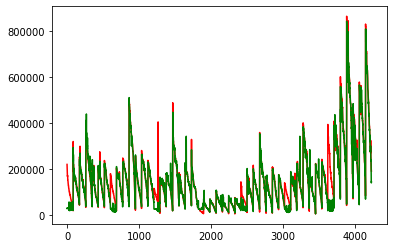

In [258]:
plt.plot(final_regional_no_outliers.DV2, color='red')
plt.plot(final_regional_no_outliers.rf_Pred, color='green')

# residual forecasting part!!

In [85]:
train = df_residual[(df_residual.QuarterIndex != 7)]
holdout = df_residual[(df_residual.QuarterIndex == 7)].reset_index()
holdout = holdout.sort_values(['GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL']).reset_index()

In [86]:
'''features = df_residual.loc[: , 'LinearReg_Pred' : 'Delta_EstIn']

plt.figure(figsize=(15, 10))  
colnm = features.columns.tolist()
mcorr = features[colnm].corr(method="spearman")  
mask = np.zeros_like(mcorr, dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True 
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
g = sns.heatmap(mcorr,  mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()'''

'features = df_residual.loc[: , \'LinearReg_Pred\' : \'Delta_EstIn\']\n\nplt.figure(figsize=(15, 10))  \ncolnm = features.columns.tolist()\nmcorr = features[colnm].corr(method="spearman")  \nmask = np.zeros_like(mcorr, dtype=np.bool)  \nmask[np.triu_indices_from(mask)] = True \ncmap = sns.diverging_palette(220, 10, as_cmap=True)  \ng = sns.heatmap(mcorr,  mask=mask, cmap=cmap, square=True, annot=True, fmt=\'0.2f\')  \nplt.show()'

In [87]:
train_x=train.loc[: , ['LassoReg_Pred', 'RF_Pred', 'ESTIMATED_IN', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
       'LinearityEstIn_rolling', 'LinearityBudget_rolling']]
train_y=train.res_rf

test_x=holdout.loc[: , ['LassoReg_Pred', 'RF_Pred', 'ESTIMATED_IN', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
       'LinearityEstIn_rolling', 'LinearityBudget_rolling']]
test_y=holdout.res_rf

In [88]:
y_pred_model1 = pd.DataFrame()


# Here I use the K-Fold validation set, but we can igore this step
X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, test_size=0.15)

In [89]:
model_name = 'Linear'
model = linear_model.LinearRegression()
fit_intercept = [False]
param_grid = {'fit_intercept': fit_intercept}
LinearReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
LinearReg_Pred = model_predict(LinearReg,test_x,test_y)
LinearReg_coef = LinearReg.coef_


model_name = 'Lasso'
model = Lasso()
fit_intercept = [False]
alph_range = np.arange(0.1,6,0.25)
param_grid = {'alpha': alph_range, 'fit_intercept': fit_intercept}
LassoReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
LassoReg_coef = LassoReg.coef_
LassoReg_Pred = model_predict(LassoReg,test_x,test_y)

model_name = 'RandomForest'
model = RandomForestRegressor()
param_grid = {'n_estimators':[100,150,200],
              'min_samples_split':[2,4,6]
             }
RF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])

RF_Pred = model_predict(RF,test_x,test_y)

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4287273.5263640685, tolerance: 1703.9017714424936

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4377115.844295724, tolerance: 1641.5933216628969

/Users/i513088/anaconda

----------------------
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)
----------------------
Train MAPE: 1019.3530019505463
The model LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False) test mape is: 168.41088824215578
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4293611.190250507, tolerance: 1703.9017714424936

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4382908.899575108, tolerance: 1641.5933216628969

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4405583.483121712, tolerance: 1692.7571251787697

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations.

----------------------
Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 871.3450188659216
The model Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) test mape is: 236.39719930864896
Finished!
----------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_s

In [90]:
result = pd.DataFrame({'SnapDate':holdout.SnapDate, 'GLOBAL_01_CODE':holdout.GLOBAL_01_CODE, 'CLOSING_QUARTER_ACTUAL':holdout.CLOSING_QUARTER_ACTUAL,
                       'test_y':holdout.test_y, 'RF_Pred':holdout.RF_Pred, 'res_rf':holdout.res_rf, 'fc_res_lr':LinearReg_Pred,'fc_res_lasso':LassoReg_Pred,'fc_res_rf':RF_Pred})

result['add_res_rf_lasso'] = result.RF_Pred + result.fc_res_lasso
result['mape_add_res_rf_lasso'] = abs(result.test_y - result.add_res_rf_lasso) / result.test_y


result['add_res_rf_lr'] = result.RF_Pred + result.fc_res_lr
result['mape_add_res_rf_lr'] = abs(result.test_y - result.add_res_rf_lr) / result.test_y


result['add_res_rf_rf'] = result.RF_Pred + result.fc_res_rf
result['mape_add_res_rf_rf'] = abs(result.test_y - result.add_res_rf_rf) / result.test_y


#result.to_csv('./res_q7new.csv', index = None, header=True, sep=';', decimal=',')

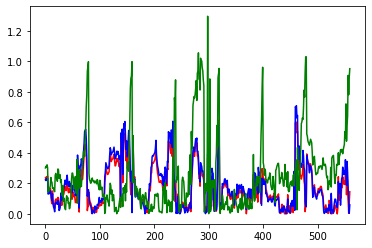

In [91]:
'''plt.plot(holdout.test_y, color='red')
plt.plot(holdout.RF_Pred, color='blue')
plt.plot(result.add_res_rf_lasso, color='green')
'''
#plt.plot(result.fc_res_lasso, color='blue')
#plt.plot(result.fc_res_rf, color='green')


plt.plot(result.mape_add_res_rf_lasso, color='red')
plt.plot(result.mape_add_res_rf_lr, color='blue')
plt.plot(result.mape_add_res_rf_rf, color='green')


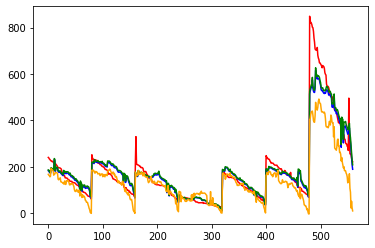

In [92]:
plt.plot(result.test_y, color='red')
plt.plot(result.add_res_rf_lasso, color='blue')
plt.plot(result.add_res_rf_lr, color='green')
plt.plot(result.add_res_rf_rf, color='orange')


In [96]:
result.columns

Index(['SnapDate', 'GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL', 'test_y',
       'RF_Pred', 'res_rf', 'fc_res_lr', 'fc_res_lasso', 'fc_res_rf',
       'add_res_rf_lasso', 'mape_add_res_rf_lasso', 'add_res_rf_lr',
       'mape_add_res_rf_lr', 'add_res_rf_rf', 'mape_add_res_rf_rf'],
      dtype='object')

In [97]:
#print(np.mean(abs(holdout.test_y-holdout.RF_Pred)/holdout.test_y))

print(np.mean(abs(result.test_y-result.RF_Pred)/result.test_y))

0.23881082788126853


In [94]:
print(np.mean(result.mape_add_res_rf_lr))
print(np.mean(result.mape_add_res_rf_lasso))
print(np.mean(result.mape_add_res_rf_rf))

0.1923711672194335
0.1705924589959723
0.25641322538520694


In [98]:
res_q1 = pd.read_csv('./res_q1.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q2 = pd.read_csv('./res_q2.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q3 = pd.read_csv('./res_q3.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q4 = pd.read_csv('./res_q4.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q5 = pd.read_csv('./res_q5.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q6 = pd.read_csv('./res_q6.csv', sep = ';', decimal=',').reset_index(drop=True)
res_q7 = pd.read_csv('./res_q7.csv', sep = ';', decimal=',').reset_index(drop=True)

a = pd.concat([res_q1,res_q2,res_q3,res_q4,res_q5,res_q6,res_q7]).reset_index(drop=True)

In [100]:
a['add_res_rf_lr'] = a.RF_Pred + a.fc_res_lr
a['mape_add_res_rf_lr'] = abs(a.test_y - a.add_res_rf_lr) / a.test_y


a['add_res_rf_rf'] = a.RF_Pred + a.fc_res_rf
a['mape_add_res_rf_rf'] = abs(a.test_y - a.add_res_rf_rf) / a.test_y

In [102]:
a.to_csv('./final_fc_res.csv', sep = ';', decimal=',')
a.head(3)

,SnapDate,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,test_y,RF_Pred,res_rf,fc_res_lr,fc_res_lasso,fc_res_rf,add_res_rf_lasso,mape_add_res_rf_lasso,add_res_rf_lr,mape_add_res_rf_lr,add_res_rf_rf,mape_add_res_rf_rf
0,2018-01-01,AP,2018-Q1,226.37125,43.937276,182.433974,-33.485139,-33.517668,13.993321,10.419608,0.953971,10.452136,0.953827,57.930596,0.744090
1,2018-01-02,AP,2018-Q1,221.71285,43.937276,177.775574,-33.485139,-33.517668,13.993321,10.419608,0.953004,10.452136,0.952857,57.930596,0.738713
2,2018-01-03,AP,2018-Q1,209.63650,43.937276,165.699224,-33.485139,-33.517668,13.993321,10.419608,0.950297,10.452136,0.950142,57.930596,0.723662


In [104]:
print(np.mean(abs(a.test_y-a.RF_Pred)/a.test_y))
print(np.mean(a.mape_add_res_rf_lr))
print(np.mean(a.mape_add_res_rf_lasso))
print(np.mean(a.mape_add_res_rf_rf))

0.616173227644851
1.2412658521725348
1.0959631056987138
0.8432936822266037


In [112]:
mape = a.groupby(['GLOBAL_01_CODE','CLOSING_QUARTER_ACTUAL']).mean()
#mape = mape[['mape_add_res_rf_lasso', 'mape_add_res_rf_lr', 'mape_add_res_rf_rf']]
#mape.to_csv('./quarterly_MAPE_res.csv', sep = ';', decimal=',')

# <font color='red'>Baseline: normal vs residual visualization </font>

In [125]:
final_fc = pd.read_csv('./final_fc.csv', sep = ';', decimal=',',index_col=0).reset_index(drop=True)
final_fc_res = pd.read_csv('./final_fc_res.csv', sep = ';', decimal=',',index_col=0).reset_index(drop=True)
quarterly_MAPE = pd.read_csv('./quarterly_MAPE.csv', sep = ';', decimal=',').reset_index(drop=True)
quarterly_MAPE_res = pd.read_csv('./quarterly_MAPE_res.csv', sep = ';', decimal=',').reset_index(drop=True)

In [144]:
final_fc_result = pd.merge(final_fc[['SnapDate', 'GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL', 'test_y', 'LinearReg_Pred', 'LassoReg_Pred', 'RF_Pred']],
                            final_fc_res[['SnapDate', 'GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL','add_res_rf_lasso', 'add_res_rf_lr', 'add_res_rf_rf']],
                           on=['SnapDate', 'GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL'], how='inner')


#final_fc_result.to_csv('./final_fc_result.csv', sep = ';', decimal=',')


In [145]:
fincal_quarterly_MAPE = pd.merge(quarterly_MAPE[['GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL', 'MAPE_Lasso', 'MAPE_Lr', 'MAPE_RF']],
                            quarterly_MAPE_res[['GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL', 'mape_add_res_rf_lasso', 'mape_add_res_rf_lr', 'mape_add_res_rf_rf']],
                           on=['GLOBAL_01_CODE', 'CLOSING_QUARTER_ACTUAL'], how='inner')

#fincal_quarterly_MAPE.to_csv('./fincal_quarterly_MAPE.csv', sep = ';', decimal=',')


In [152]:
final_fc_result = pd.read_csv('./final_fc_result.csv', sep = ';', decimal=',',index_col=0)
fincal_quarterly_MAPE = pd.read_csv('./fincal_quarterly_MAPE.csv', sep = ';', decimal=',',index_col=0)

In [153]:
final_fc_result.head(3)

,SnapDate,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,DV2,Linear,Lasso,RF,RF_res_lasso,RF_res_lr,RF_res_rf
0,01.01.18,AP,2018-Q1,226.37125,0.0,0.0,43.937276,10.419608,10.452136,57.930596
1,02.01.18,AP,2018-Q1,221.71285,0.0,0.0,43.937276,10.419608,10.452136,57.930596
2,03.01.18,AP,2018-Q1,209.63650,0.0,0.0,43.937276,10.419608,10.452136,57.930596


In [154]:
fincal_quarterly_MAPE.head(3)

,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,MAPE_Lasso,MAPE_Lr,MAPE_RF,MAPE_res_rf_lasso,MAPE_res_rf_lr,MAPE_res_rf_rf
0,AP,2018-Q1,1.372446,1.372440,0.975859,2.223550,2.341144,1.247194
1,AP,2018-Q2,0.362852,0.362841,0.267636,0.496096,0.513410,0.249725
2,AP,2018-Q3,0.988472,0.988463,0.311462,1.071914,1.094023,0.364805


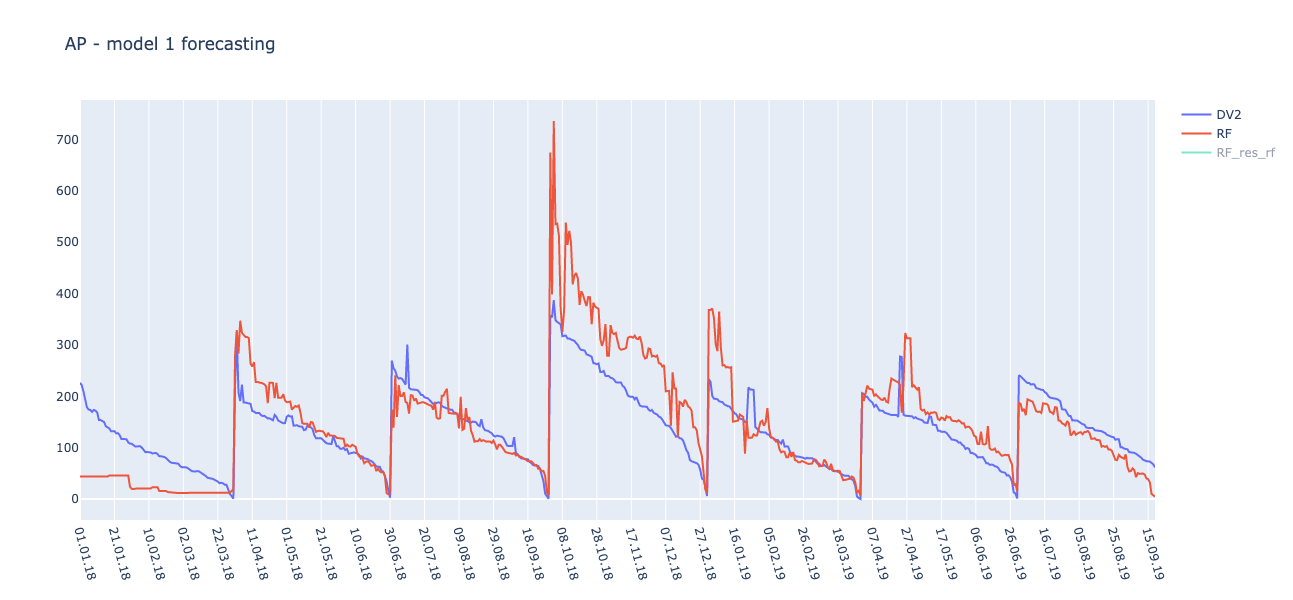

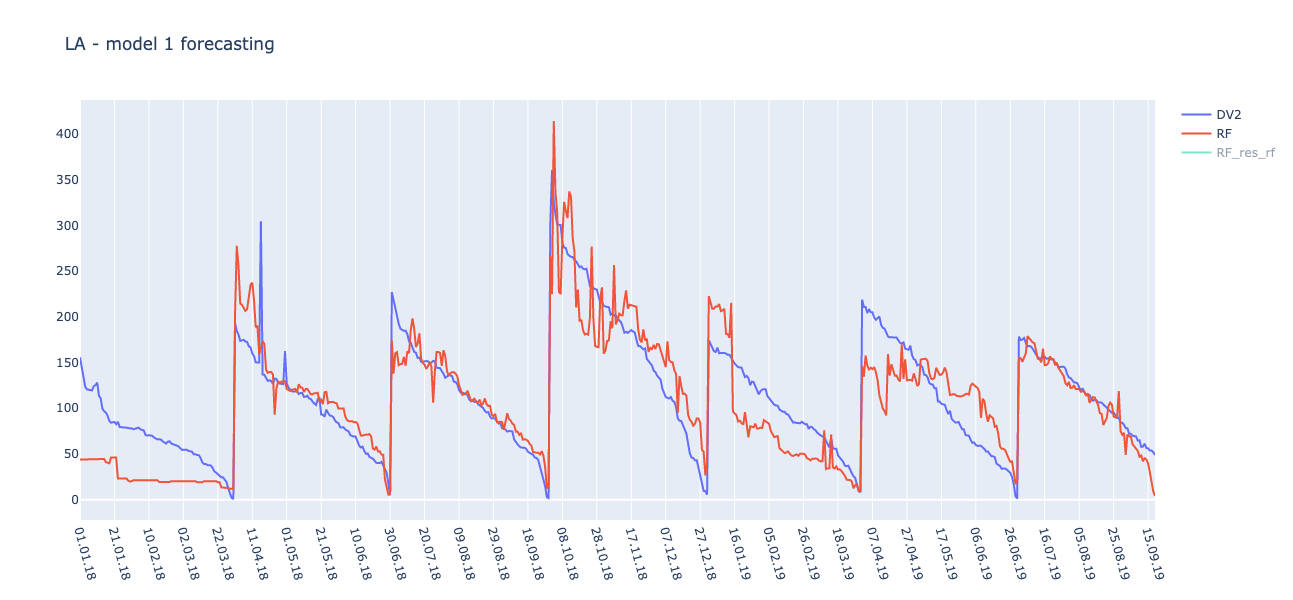

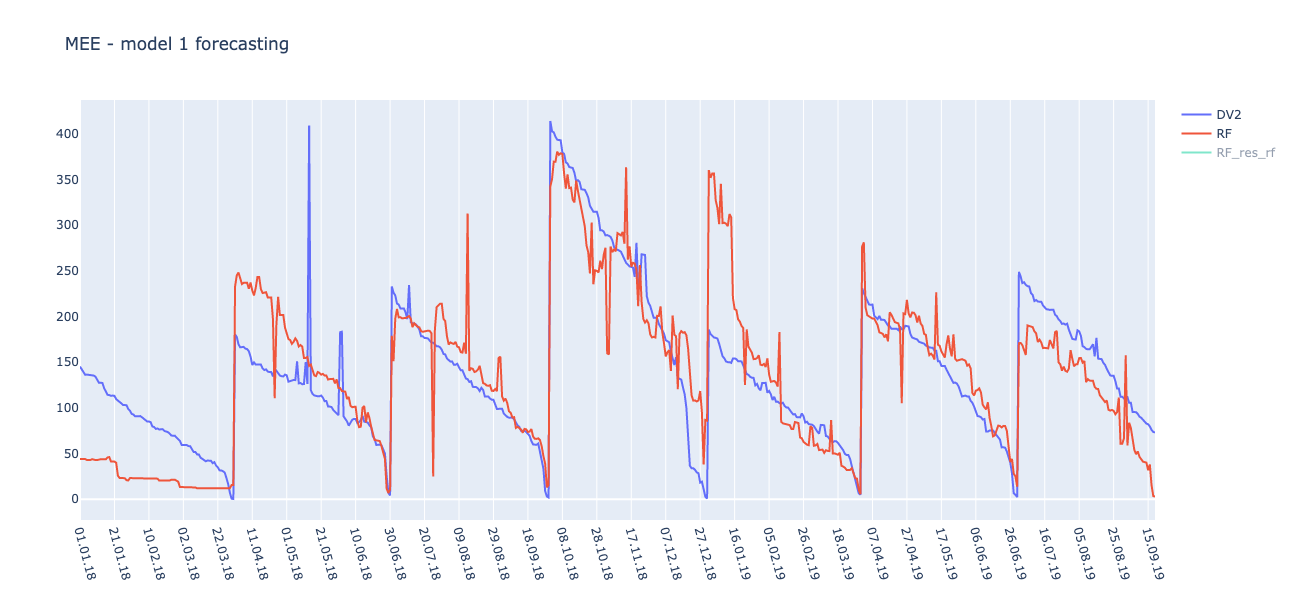

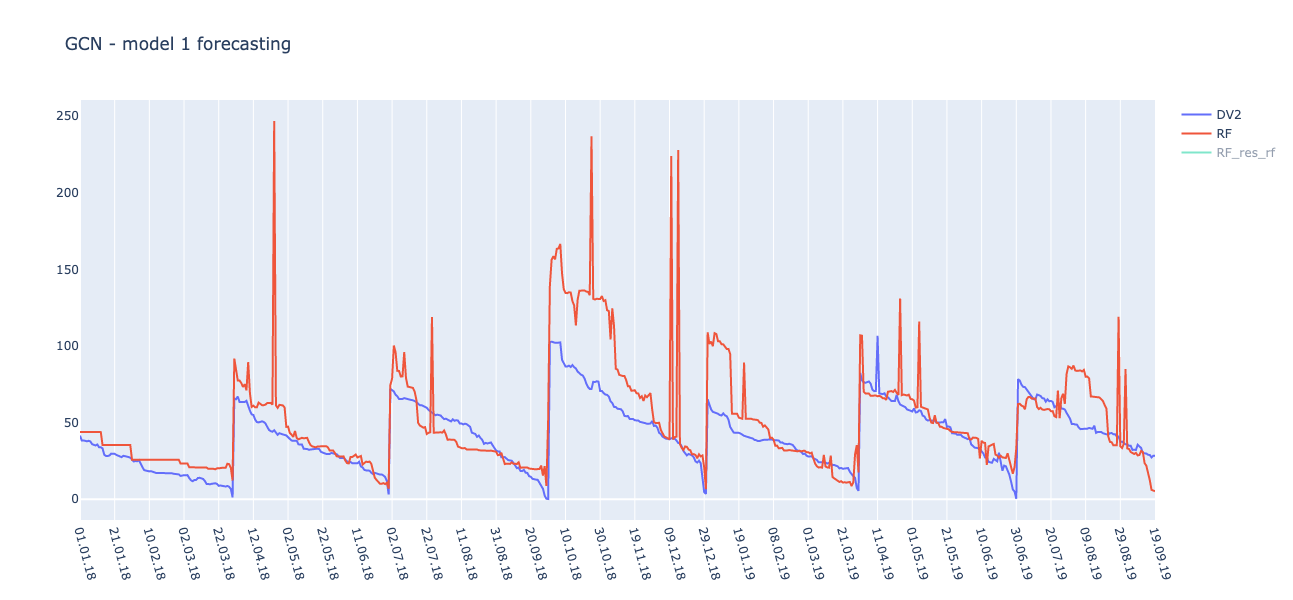

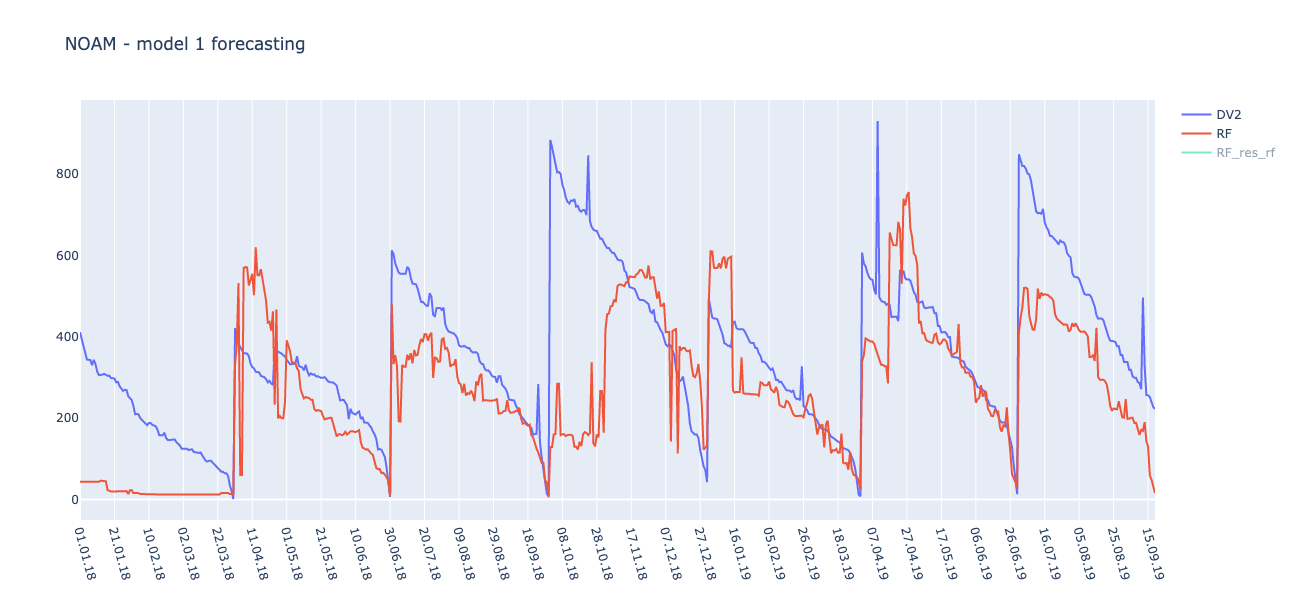

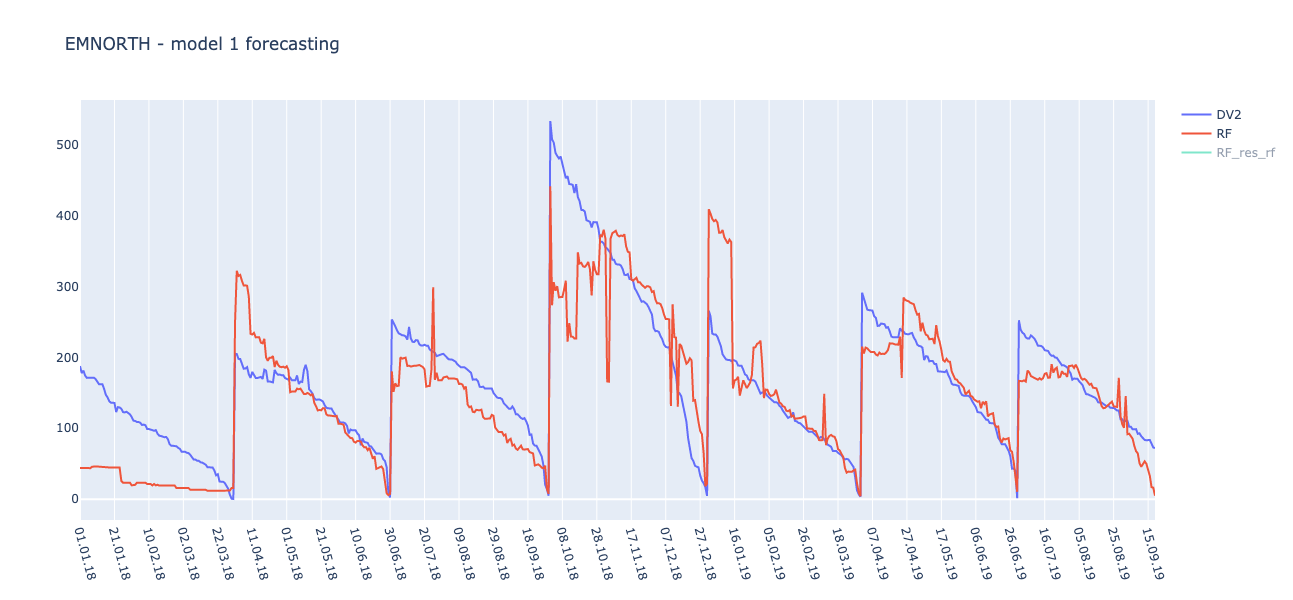

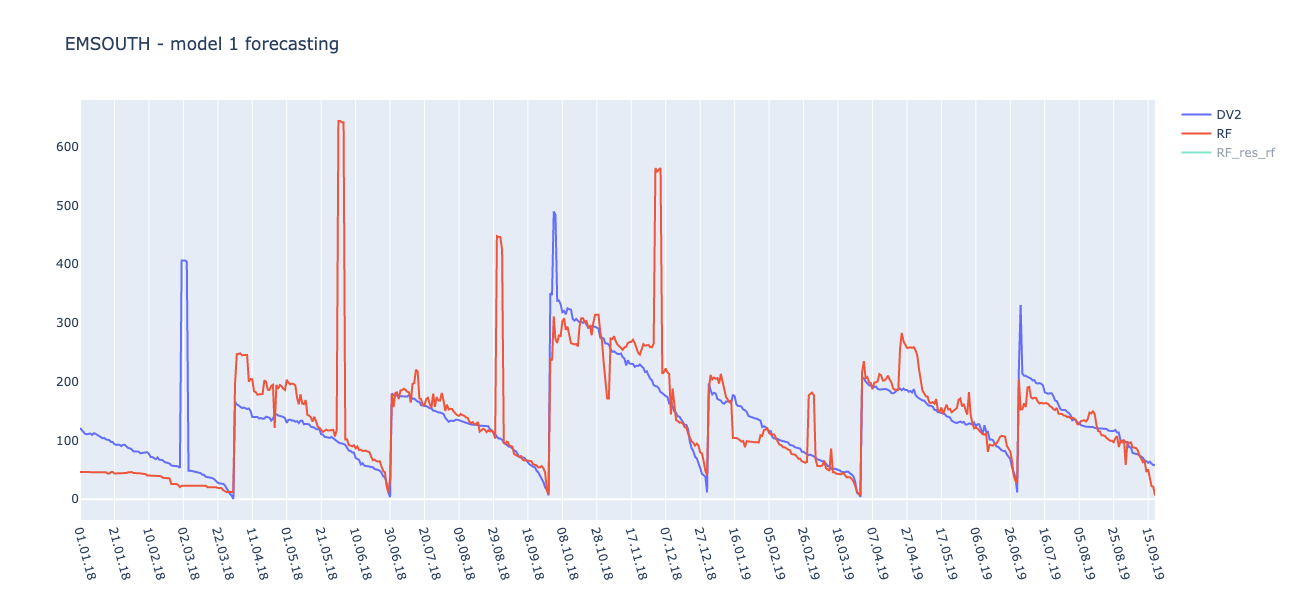

In [157]:
dataset = final_fc_result
compares = ['DV2','RF','RF_res_rf']   #['test_y','LassoReg_Pred', 'RF_Pred']
regions = ['AP','LA','MEE','GCN','NOAM','EMNORTH', 'EMSOUTH']
quarters = ['2018-Q1','2018-Q2','2018-Q3','2018-Q4','2019-Q1','2019-Q2','2019-Q3']
title_str = 'model 1 forecasting'

visulization(dataset, compares, regions, quarters, title_str)

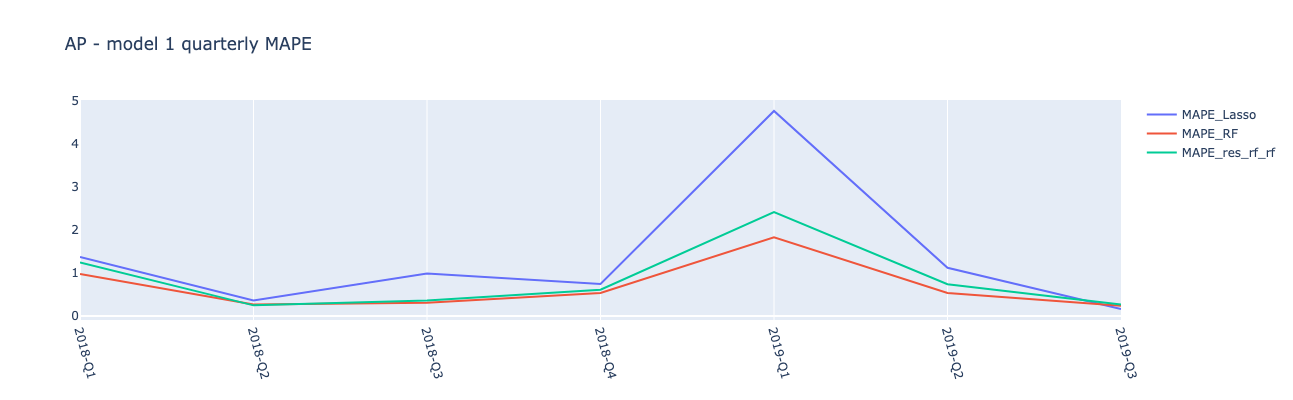

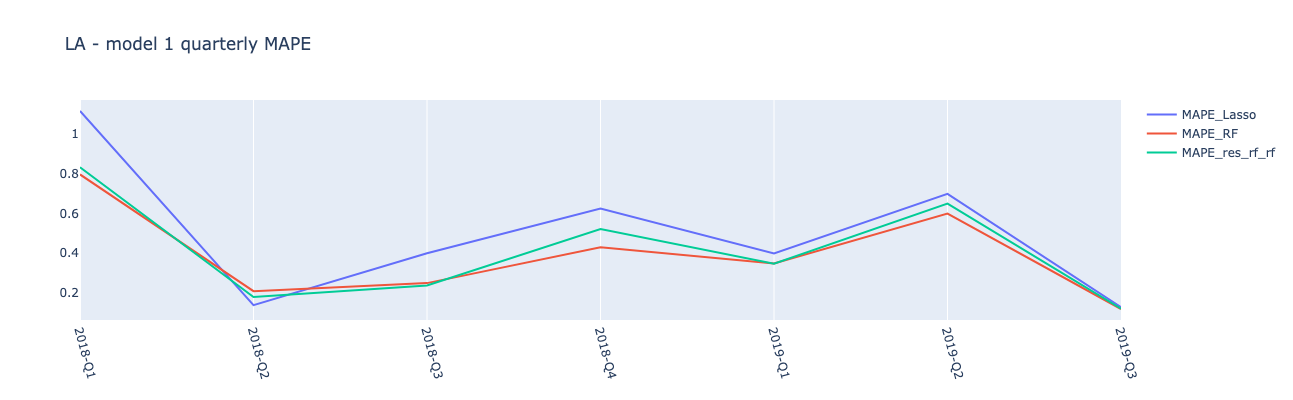

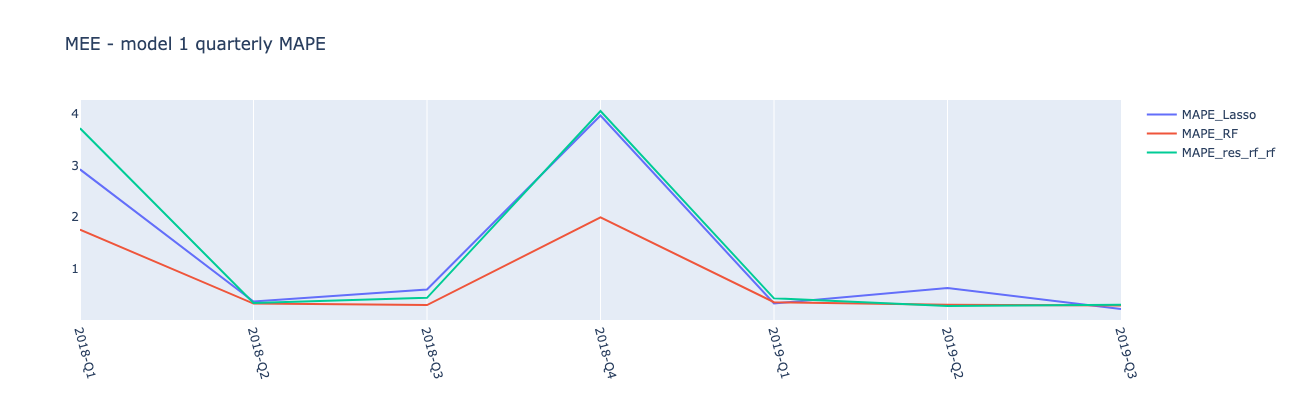

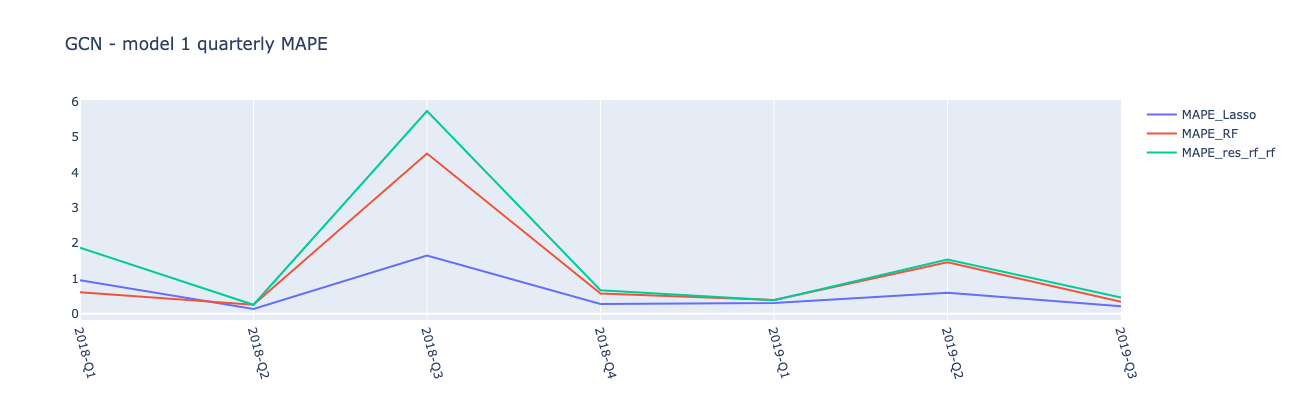

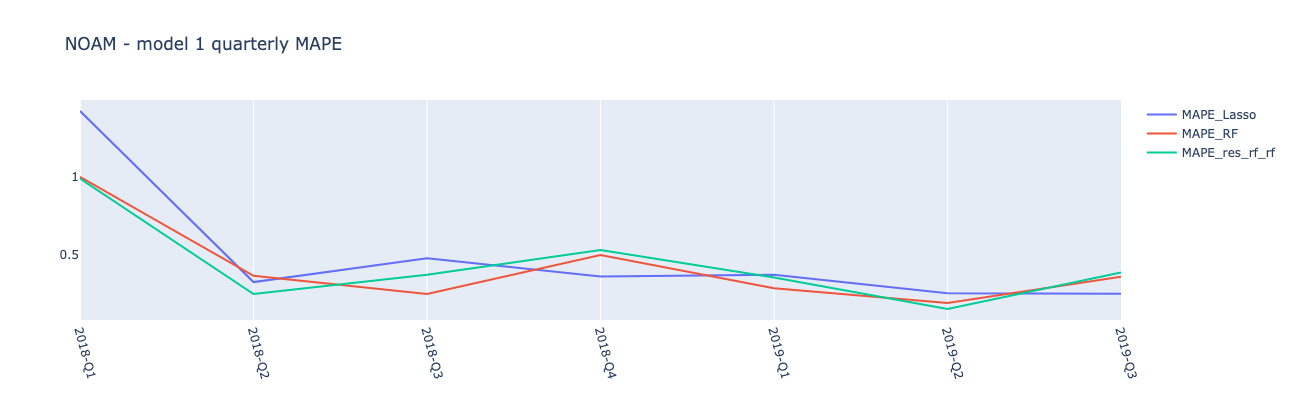

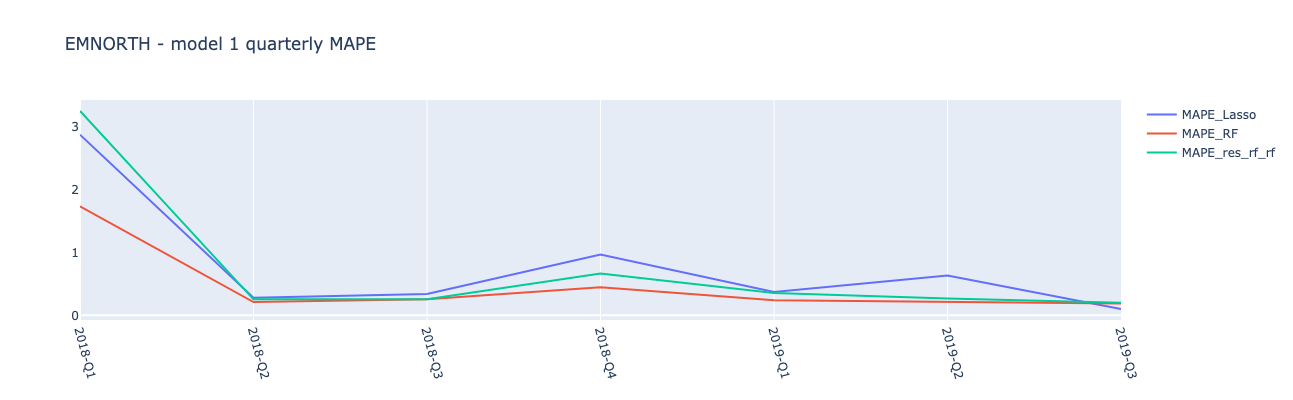

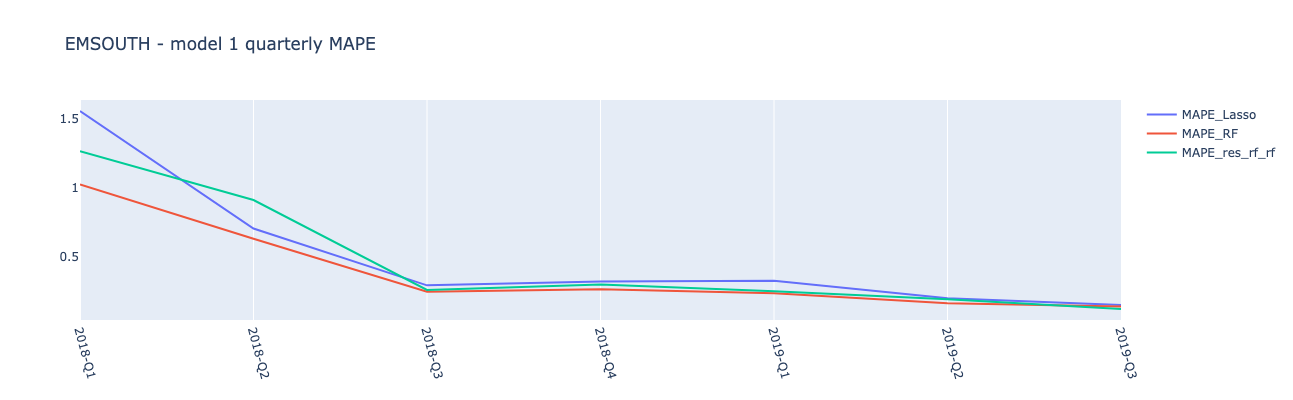

In [156]:
dataset = fincal_quarterly_MAPE
compares = ['MAPE_Lasso', 'MAPE_RF', 'MAPE_res_rf_rf']   #['test_y','LassoReg_Pred', 'RF_Pred']
regions = ['AP','LA','MEE','GCN','NOAM','EMNORTH', 'EMSOUTH']
quarters = ['2018-Q1','2018-Q2','2018-Q3','2018-Q4','2019-Q1','2019-Q2','2019-Q3']
title_str = 'model 1 quarterly MAPE'

visulization(dataset, compares, regions, quarters, title_str)

### MLP

In [184]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop
from keras import optimizers


batch_size = 50
epochs = 600
input_shape=(4,)
    
kf = KFold(n_splits=4, random_state=None, shuffle=True)

# Building the MLP model

model = Sequential()

model.reset_states() 
model.add(Dense(256,activation='linear',input_shape=input_shape))
#model.add(Dense(128,activation='relu',input_shape=input_shape))
#model.add(Dense(128,activation='linear'))
model.add(Dense(64,activation='linear'))
model.add(Dense(32,activation='linear'))
model.add(Dense(1,activation='linear'))


model.compile(loss='mae', optimizer=optimizers.Adagrad(lr=0.15, epsilon=None, decay=0.01))

model.summary()

for train_index, test_index in kf.split(train_x):
    
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    x_train, x_test = train_x.iloc[train_index], train_x.iloc[test_index]
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]

    x_train = np.reshape(x_train,(len(x_train),4))
    x_test = np.reshape(x_test,(len(x_test),4))
    
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    x_test = x_test.astype('float32')
    y_test = y_test.astype('float32')
    
    model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(x_test,y_test))



predicted_train = model.predict(train_x)
predicted_train = np.reshape(predicted_train, np.shape(train_y))
mape_train = np.mean(MAPE(train_y, predicted_train))


predicted_test = model.predict(test_x)
mlp_predicted_test = np.reshape(predicted_test, np.shape(test_y))
mape_test = np.mean(MAPE(mlp_predicted_test, test_y))


y_pred_model1['MLP'] = pd.Series(mlp_predicted_test)
    
y_pred_model1['MLP_mape'] = pd.Series(MAPE(mlp_predicted_test, test_y))
    
#y_pred_model1.to_csv('/Users/i513088/Desktop/y_pred_model1_count-Q5.csv')
    
    
#print('mae score_train:',score_train)
print('MAPE_train is: ', mape_train,'%')

#print('mae score_test:',score_test)
print('MAPE_test is: ', mape_test,'%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 19,841
Trainable params: 19,841
Non-trainable params: 0
_________________________________________________________________
MAPE_train is:  inf %


/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning:

divide by zero encountered in true_divide



NameError: name 'score_test' is not defined

In [158]:
#print('MAPE_train is: ', mape_train,'%')

#print('MAPE_test is: ', mape_test,'%')